In [1]:
import numpy as np
import cPickle as pickle
import os 
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import pandas as pd
from sklearn.preprocessing import LabelEncoder, Imputer
from itertools import cycle
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
def load_pickle(filename):
    with open(filename +'.pickle', 'rb') as handle:
        data = pickle.load(handle)
        return data

In [3]:
def create_dataset(df, columns, complete=False):
    if complete:
        tmp_df = df[~df.loc[:, np.append("Dx", columns)].T.isnull().any()]
    else:
        tmp_df = df[~df.loc[:, ["Dx"]].T.isnull().any()]

    # remove subjects whom miss over 10% of their features

    #         nans_per_subject = tmp_df.loc[:, tmp_df.columns.values[:]].isnull().T.sum()
    #         completeness_per_subject = (float(tmp_df.shape[1]) - nans_per_subject) / tmp_df.shape[1]
    #         tmp_df = tmp_df.loc[completeness_per_subject >= 0.9]

    X = tmp_df.loc[:, columns].as_matrix()
    y = tmp_df.loc[:, "Dx"].values.astype(int)

    tmp_df['age_group_tesla_site'] = tmp_df["age_group"] + tmp_df["tesla"] + tmp_df["site"]
    le = LabelEncoder()
    groups = le.fit_transform(tmp_df.age_group_tesla_site.values)

    return X, y, groups

In [4]:
def get_spaced_colors(n):
    max_value = 255**3
    interval = int(max_value / n)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]

    return [(int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16)) for i in colors]

In [143]:
def plot_results(fracs, strategies, score, metric_label, missing_data_percentage):

    data_mean = np.nanmean(score, axis=1)
    data_sd = np.nanstd(score, axis=1)

    y_min = np.nanmin(data_mean - data_sd)
    y_max = np.nanmax(data_mean + data_sd)

    fig = plt.figure(figsize=(30, 15))

    color_palette = ['y', 'r', 'g', 'c', 'm', 'b']

    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_palette, ls=["--",":","-.","-","--",":"])

    plt.ylabel(metric_label, size='x-large')
    plt.ylim([0, 10])

    for i, strategy in enumerate(strategies):
        x = fracs
        y = data_mean[:, i]
        std = data_sd[:, i]
        
        mask = np.isfinite(y)
        
#         if strategy == 'mice':
#             return x, y, std
        
        plt.plot(x[mask], y[mask], label=strategy, alpha=0.4, lw=2.5)
        plt.fill_between(x[mask], y[mask] - std[mask], y[mask] + std[mask], 
                         alpha=0.2)


    plt.axvline(x=missing_data_percentage, color='black', ls='dashed', alpha=0.5)
    
    ticks = np.arange(0, max(fracs) + 0.05, 0.05)
    labels = [str(int(tick * 100)) for tick in ticks]

    plt.xticks(ticks, labels, rotation=45)
    plt.xlabel('Missing data %', size='x-large')
    plt.legend()

    #TODO fix legend https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
    plt.show()
    fig.savefig(metric_label + '.png')

    pp = PdfPages(metric_label + '.pdf')
    pp.savefig(fig)
    pp.close()

In [6]:
fracs = np.arange(1, 91) / 100.

n_resample = 100

metric_labels = ['masked_MAE_scores', 'masked_MSE_scores', 'masked_RMSE_scores',
                 'masked_NMAE_scores', 'masked_NMSE_scores', 'masked_NRMSE_scores',
                 'MAE_scores', 'MSE_scores', 'RMSE_scores',
                 'NMAE_scores', 'NMSE_scores', 'NRMSE_scores']

data_dir= "/data/wbbruin/Desktop/ENIGMA_OCD"
ENIGMA_OCD_df = pd.DataFrame.from_csv(os.path.join(data_dir, "ENIGMA_OCD_df.csv"))
ENIGMA_OCD_df.head()

ENIGMA_OCD_df['age_group_tesla_site'] = ENIGMA_OCD_df["age_group"] + ENIGMA_OCD_df["tesla"] + ENIGMA_OCD_df["site"]

columns_to_choose = range(3, len(ENIGMA_OCD_df.columns) - 1)
columns_to_choose.pop(1)
columns_to_choose.pop(1)

columns_to_choose = ENIGMA_OCD_df.columns.values[columns_to_choose]

X_tot, y_tot, groups_tot = create_dataset(ENIGMA_OCD_df, columns_to_choose, complete=False)
X_c_tot, y_c_tot, groups_c_tot = create_dataset(ENIGMA_OCD_df, columns_to_choose, complete=True)

# Calculate NaNs per column (features)
nans_per_column = np.isnan(X_tot).sum(axis=0)

missing_data_percentage = float(nans_per_column.sum()) / X_tot.size

# Obtain a complete dataset without NaNs that we can use for imputation simulations
X_without_NaNs = X_c_tot.copy()

bool_nan_ind_container = load_pickle('simulated_nans_data')

/data/wbbruin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
scores_container = load_pickle('imputation_scores')

In [8]:
missing_data_percentage

0.025613905325443786

In [9]:
np.mean(scores_container[1, :, 3, 5])

0.92320549920139028

In [10]:
np.isnan(scores_container).any()

False

In [14]:
bool_nan_ind_container = load_pickle('simulated_nans_data')

In [15]:
def run_imputation(X_with_nans, strategy):
    if strategy == "mean":
        mean_imputer = Imputer(missing_values='NaN', strategy="mean", axis=0)
        X_imputed = mean_imputer.fit_transform(X_with_nans)
    elif strategy == "median":
        median_imputer = Imputer(missing_values='NaN', strategy="median", axis=0)
        X_imputed = median_imputer.fit_transform(X_with_nans)
    else:
        X_imputed = np.nan
    return X_imputed

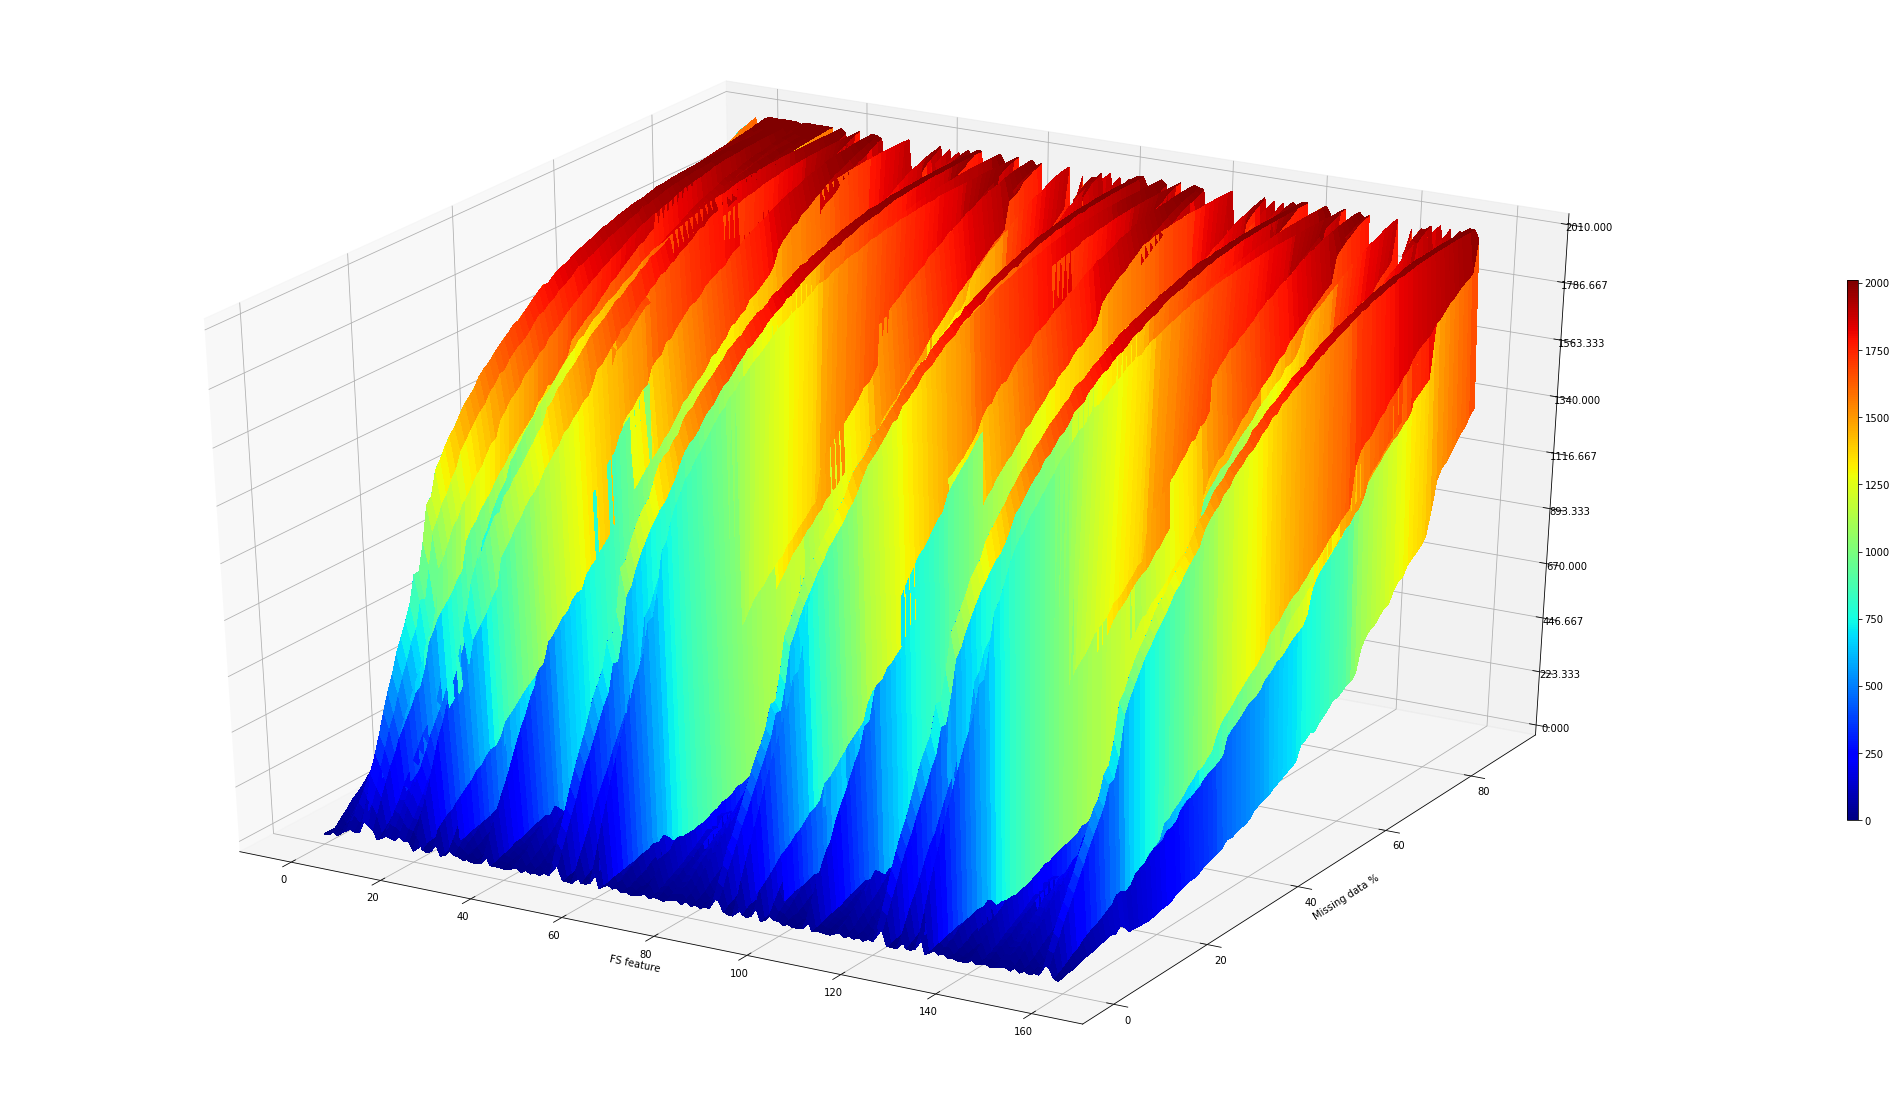

In [17]:
b = np.zeros((160, 100, 90), dtype=int)
for fi in range(len(fracs)):
    a = np.zeros_like(bool_nan_ind_container[0, 0], dtype=int)
    for n in range(n_resample):
        a += bool_nan_ind_container[fi, n]
        b[:, n, fi] = bool_nan_ind_container[fi, n].sum(axis=0)

    n_duplicates = np.where(a == 100)[0].size
#     print np.round((float(n_duplicates) / a.size) * 100, decimals=2)

average_missers_per_c = b.mean(axis=1).T

fig = plt.figure(figsize=(30, 15))
ax = Axes3D(fig)
X, Y = np.meshgrid(range(160), range(90))

# This is the part you want:
Z1 = np.zeros(X.shape, float)

surf = ax.plot_surface(X, Y, average_missers_per_c, rstride=1, cstride=1, cmap=cm.jet,
        linewidth=0, antialiased=False)

plt.xlabel('FS feature')  
plt.ylabel('Missing data %')
ax.w_zaxis.set_major_locator(LinearLocator(10))
ax.w_zaxis.set_major_formatter(FormatStrFormatter('%.03f'))    
fig.colorbar(surf, shrink=0.5, aspect=50)    
plt.show()

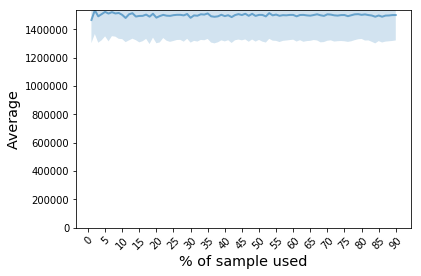

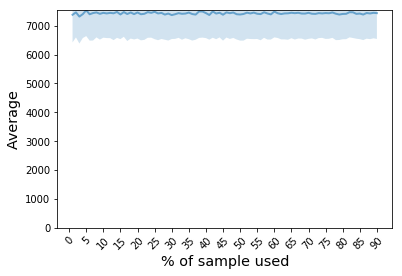

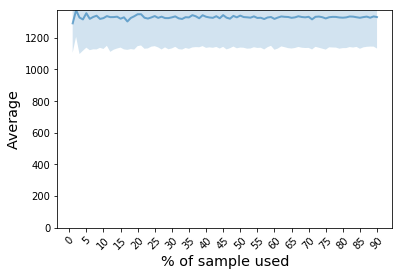

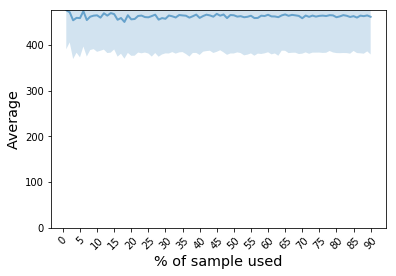

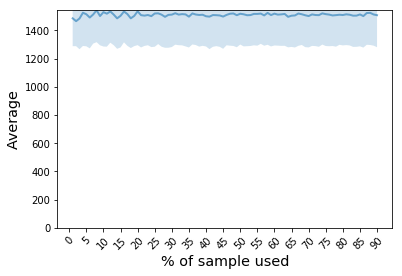

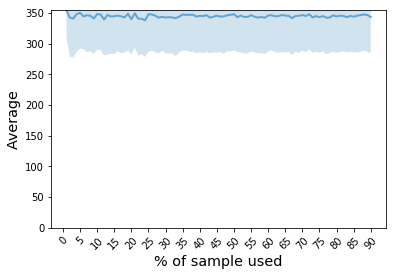

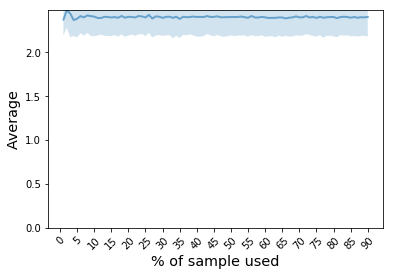

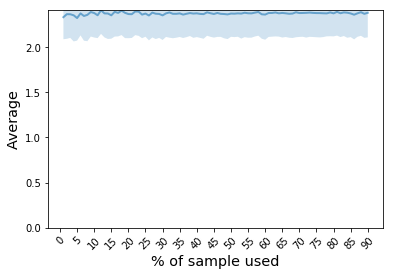

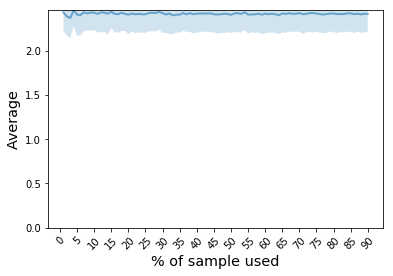

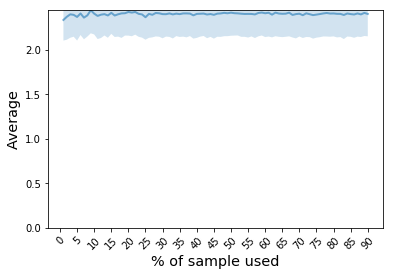

In [18]:
n_features = 10
averages = np.zeros((n_features, len(fracs)))
stds = np.zeros((n_features, len(fracs)))

for i_c, c in enumerate(np.round(np.linspace(2, 159, n_features))):
    c = int(c)
    for i_f, f in enumerate(fracs):
        n_to_pick = int(np.round(f * X_without_NaNs.shape[0]))
        i_to_pick = np.random.choice(range(X_without_NaNs.shape[0]), n_to_pick)
        
        averages[i_c, i_f] = np.mean(X_without_NaNs[i_to_pick, c])
        stds[i_c, i_f] = np.std(X_without_NaNs[i_to_pick, c])
        
for i in range(len(averages)):

    plt.plot(fracs, averages[i, :], alpha=0.6, lw=2)
    plt.ylim([0, np.max(averages[i, :])])
    
    plt.fill_between(fracs, averages[i, :] - stds[i, :], averages[i, :] + stds[i, :], 
                         alpha=0.2)

    ticks = np.arange(0, max(fracs) + 0.05, 0.05)
    labels = [str(int(tick * 100)) for tick in ticks]

    plt.ylabel("Average", size='x-large')

    plt.xticks(ticks, labels, rotation=45)
    plt.xlabel('% of sample used', size='x-large')
    plt.legend()

    plt.show()

In [19]:
less_fracs = (np.append(np.arange(10), (np.arange(9) + 1) * 10)) / float(100)
less_fracs = less_fracs[1:]

In [32]:
scores_1 = load_pickle('mice_imputation_scores_1')
print np.sum(scores_1 == 0)
print scores_1.shape
print len(less_fracs) * 50 * 1 * 12
print np.sum(scores_1 != 0) == len(less_fracs) * 50 * 1 * 12

97200
(90, 100, 1, 12)
10800
True


In [33]:
scores_2 = load_pickle('mice_imputation_scores_0')
print np.sum(scores_2 == 0)
print scores_2.shape
print len(less_fracs) * 50 * 1 * 12
print np.sum(scores_2 != 0) == len(less_fracs) * 50 * 1 * 12

97200
(90, 100, 1, 12)
10800
True


In [34]:
scores = scores_1 + scores_2
print np.sum(scores == 0)
print scores.shape
print len(less_fracs) * 100 * 1 * 12
print np.sum(scores != 0) == len(less_fracs) * 100 * 1 * 12

86400
(90, 100, 1, 12)
21600
True


In [35]:
scores[scores == 0] = np.nan

In [36]:
with open(('mice_imputation_scores.pickle'), 'wb') as handle:
    pickle.dump(scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
print scores.shape
print scores_container.shape
all_scores = np.zeros((90, 100, 7, 12))

all_scores[:, :, :6, :] = scores_container
all_scores[:, :, [6], :] = scores

with open(('complete_imputation_scores.pickle'), 'wb') as handle:
    pickle.dump(all_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

(90, 100, 1, 12)
(90, 100, 6, 12)


In [112]:
metric_labels

['masked_MAE_scores',
 'masked_MSE_scores',
 'masked_RMSE_scores',
 'masked_NMAE_scores',
 'masked_NMSE_scores',
 'masked_NRMSE_scores',
 'MAE_scores',
 'MSE_scores',
 'RMSE_scores',
 'NMAE_scores',
 'NMSE_scores',
 'NRMSE_scores']

/data/wbbruin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


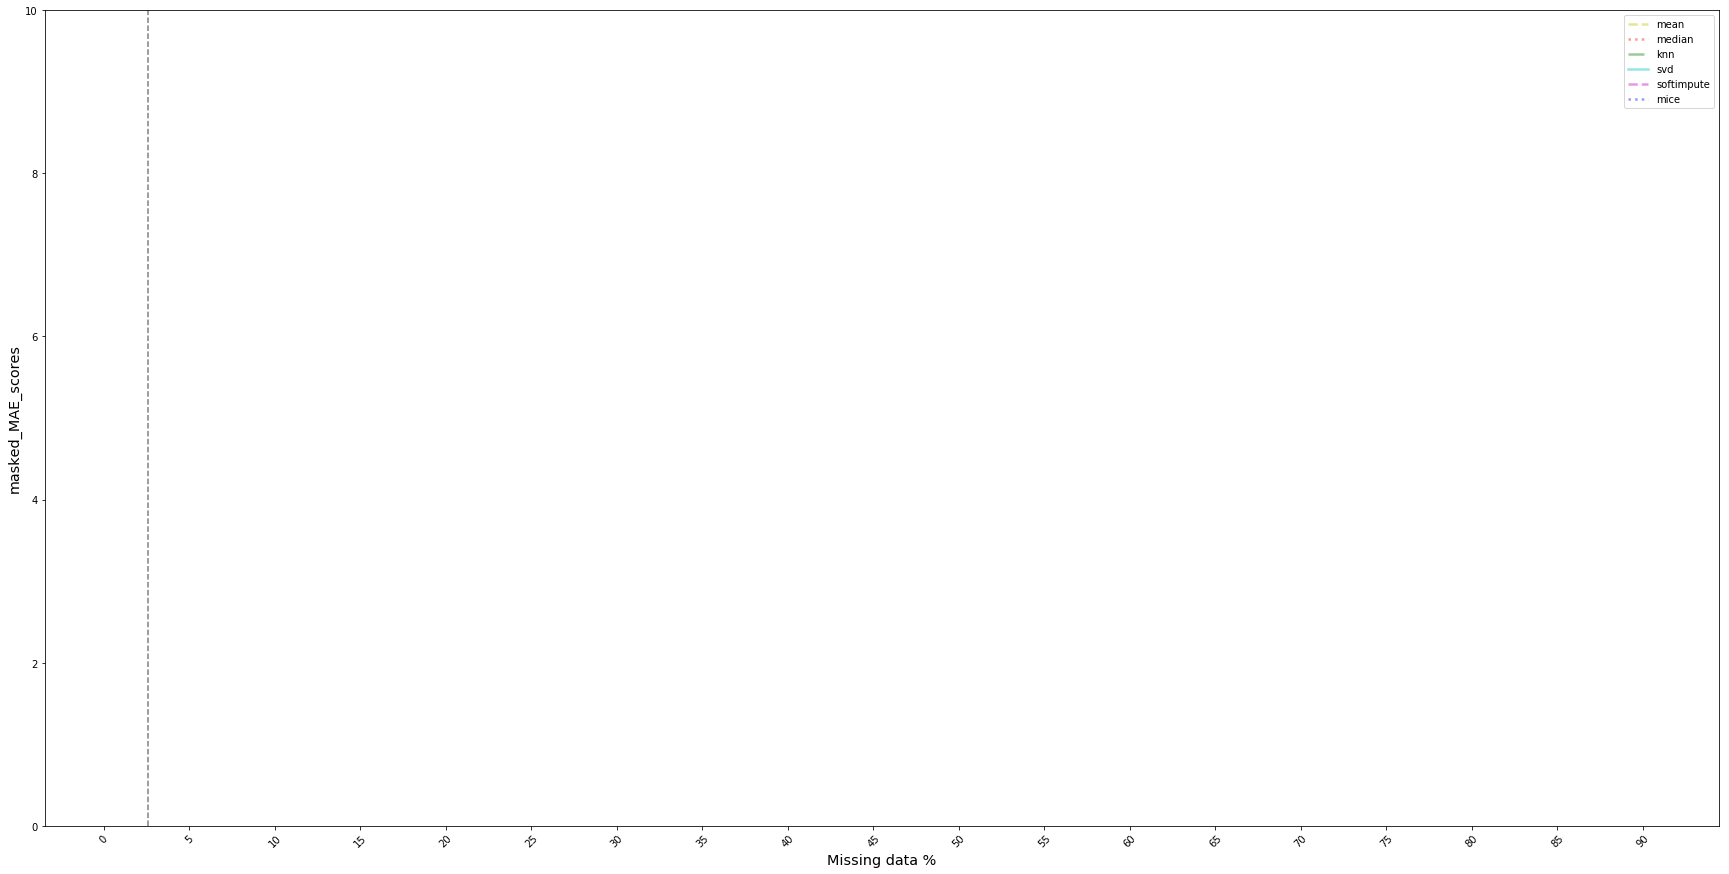

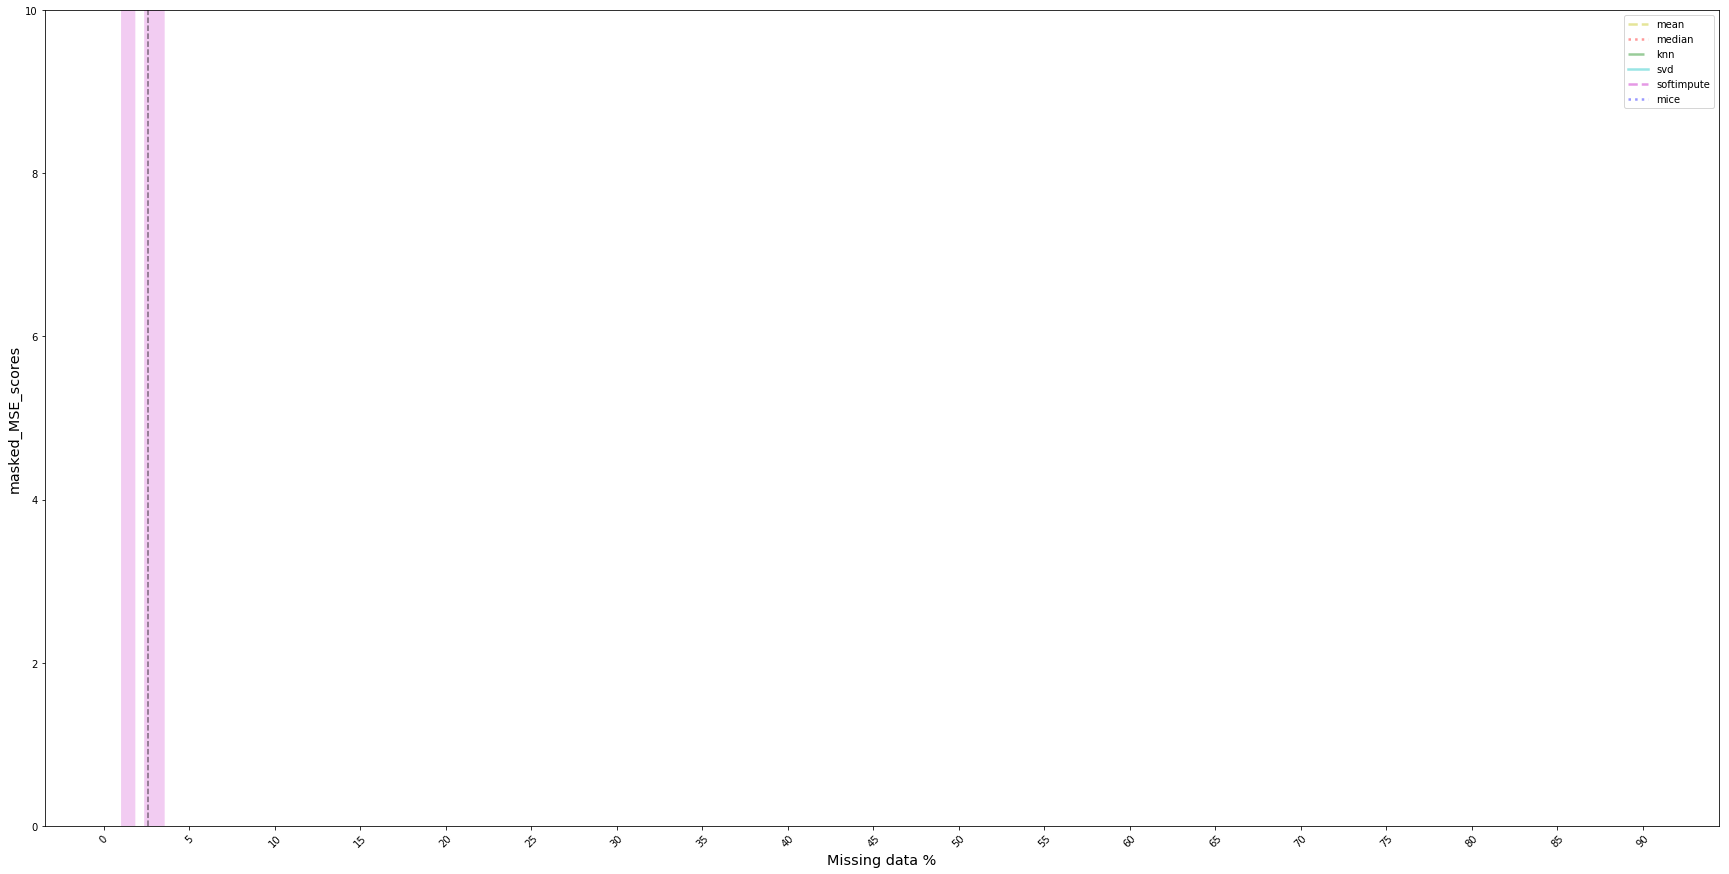

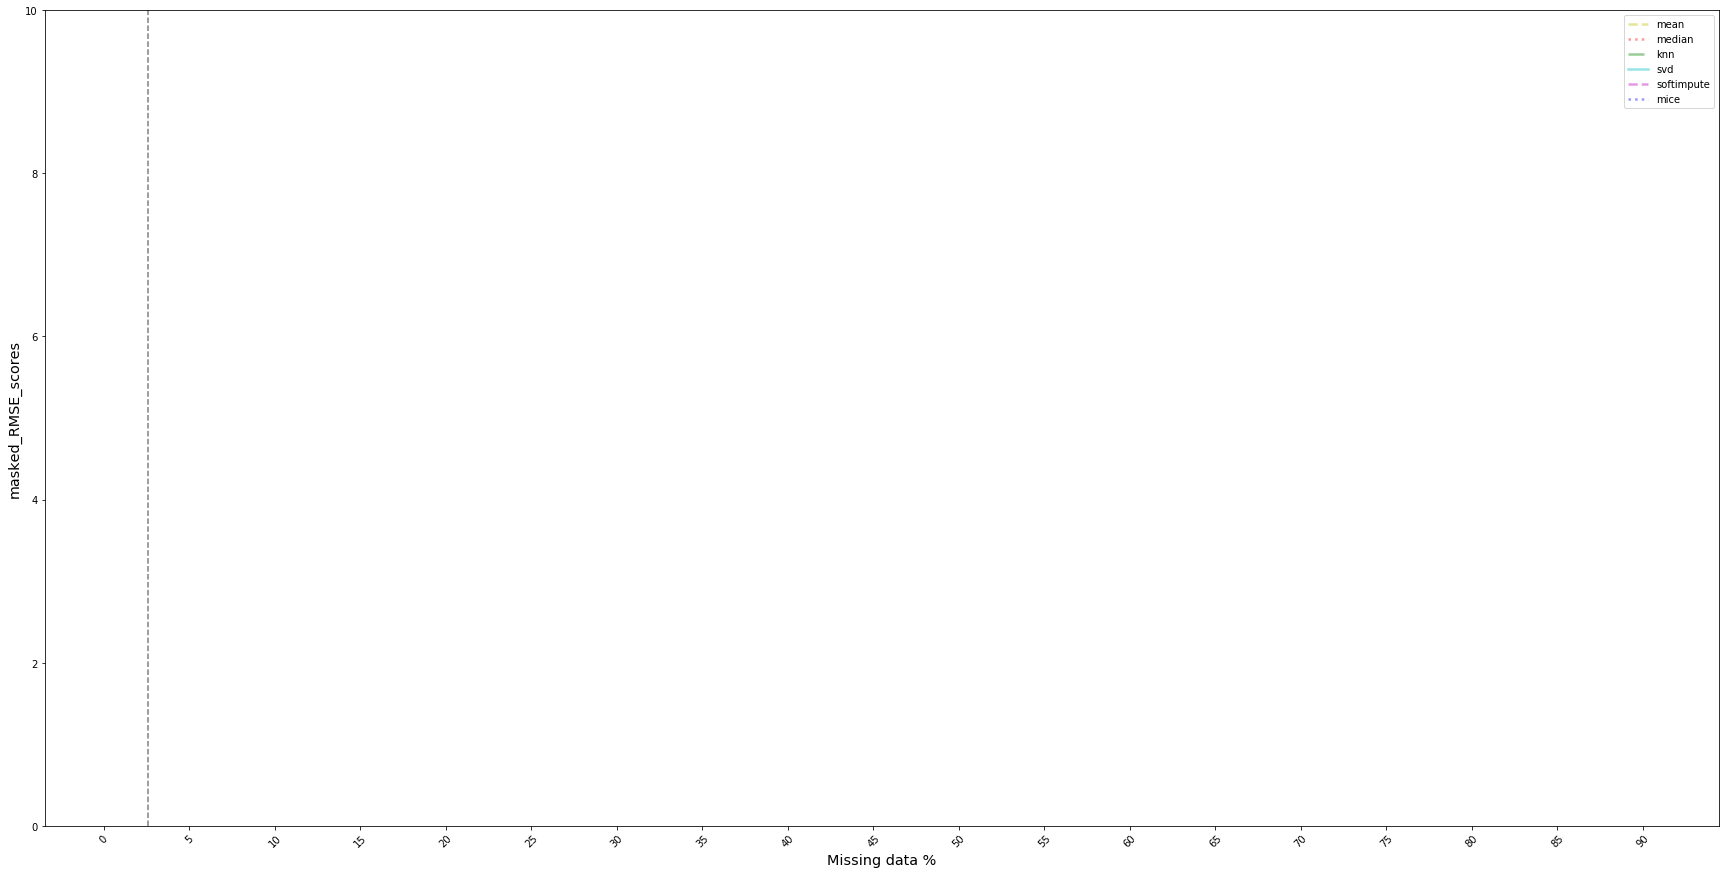

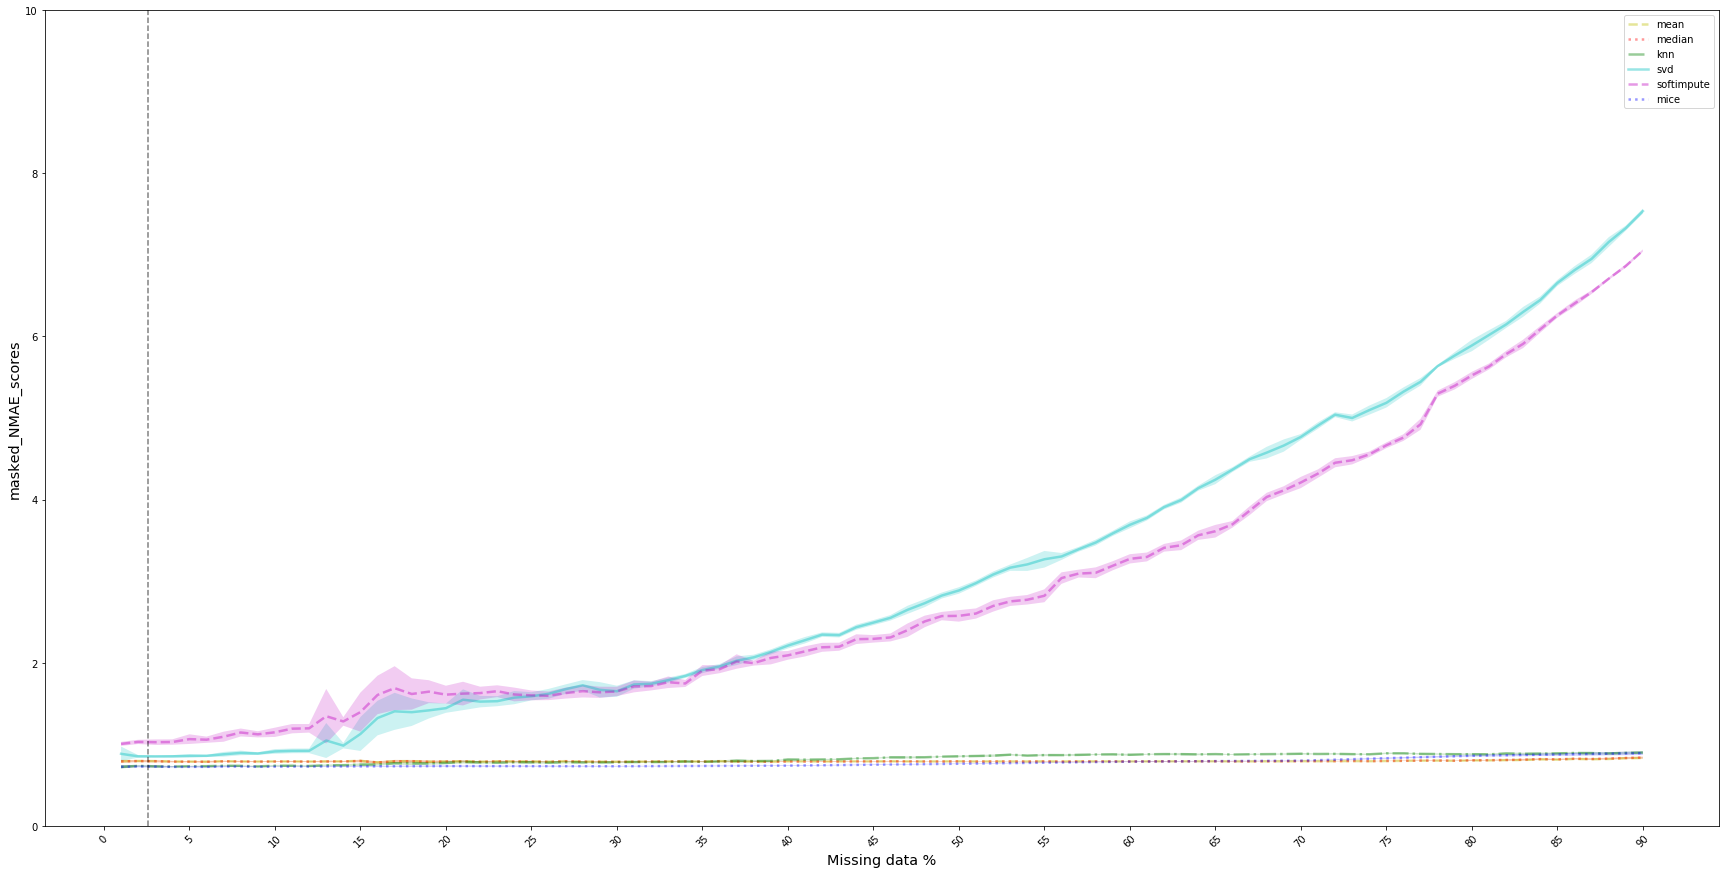

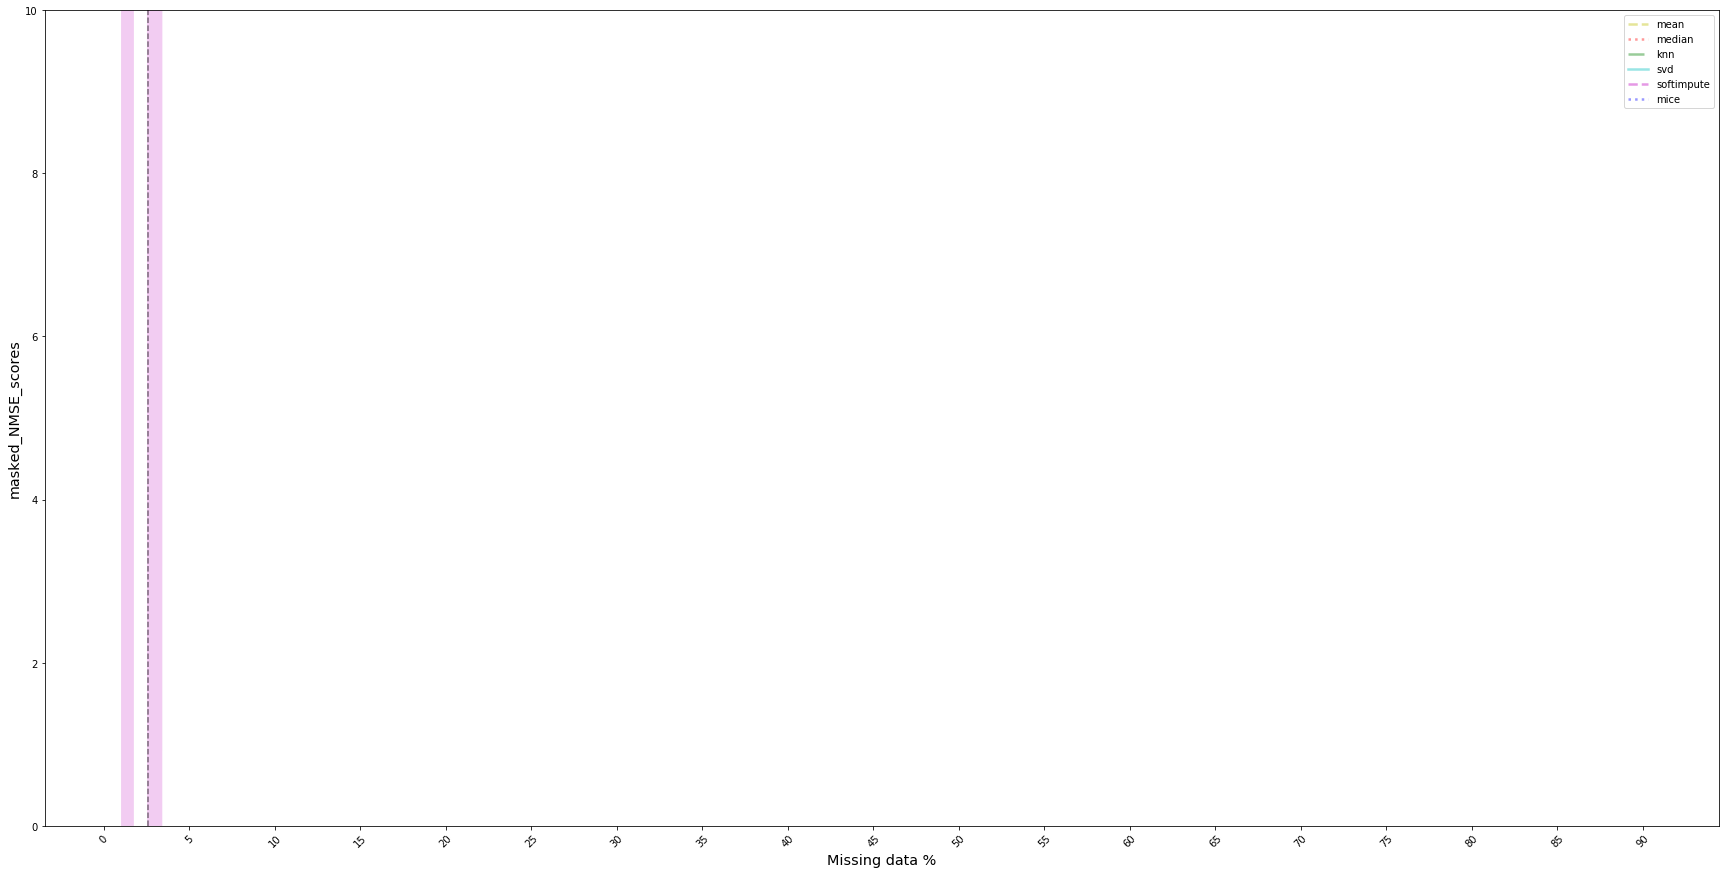

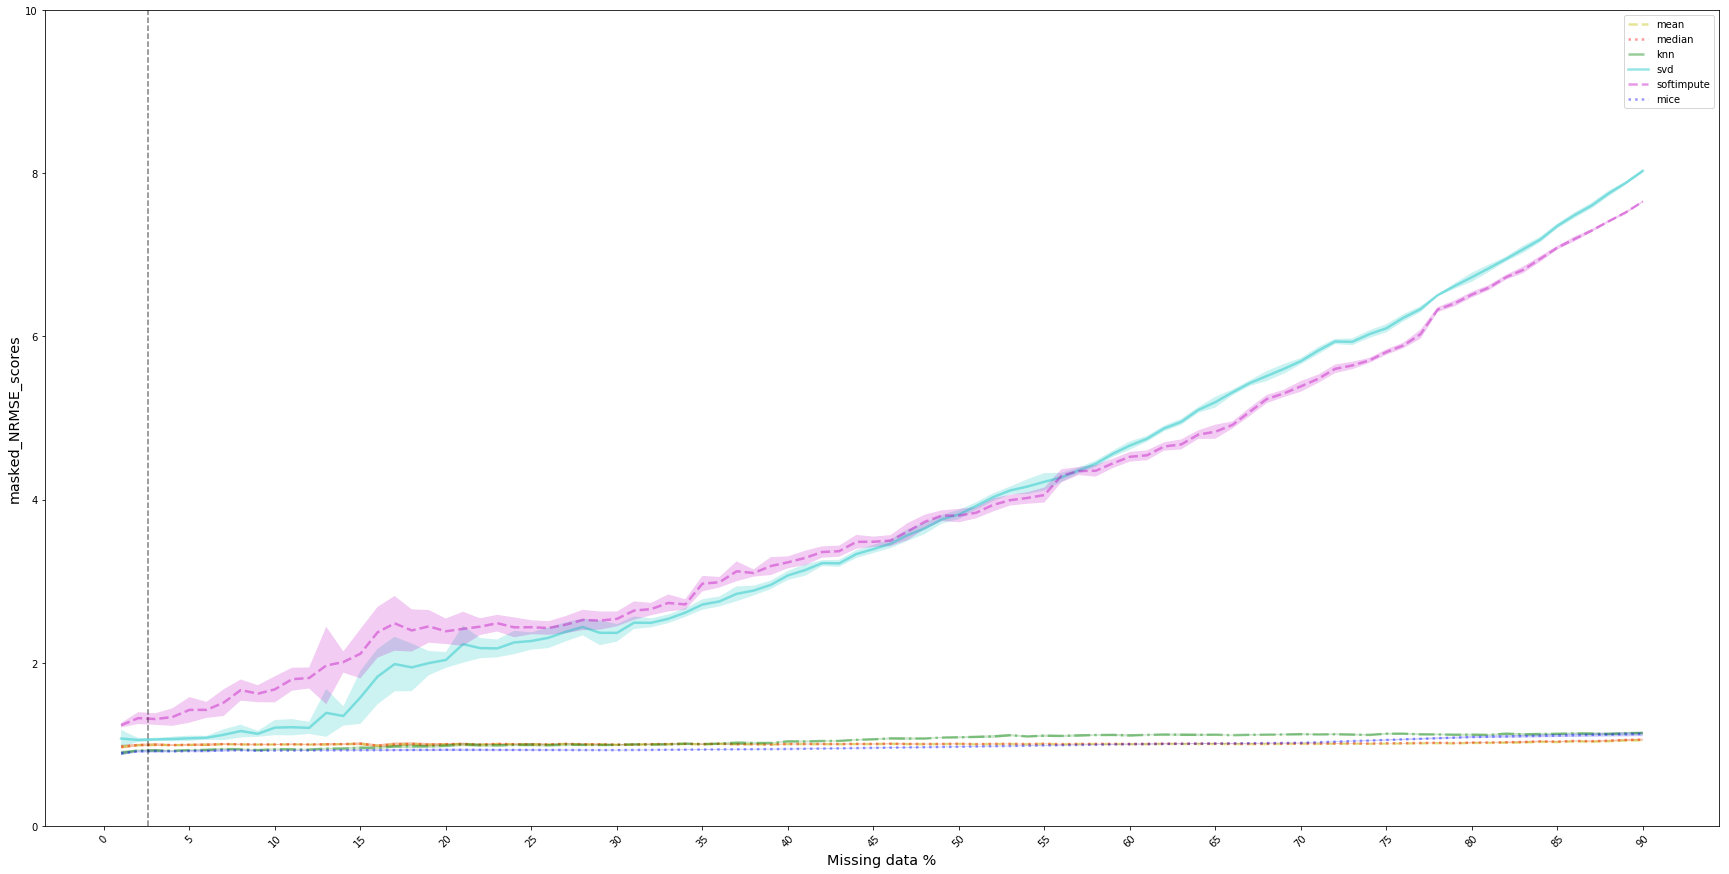

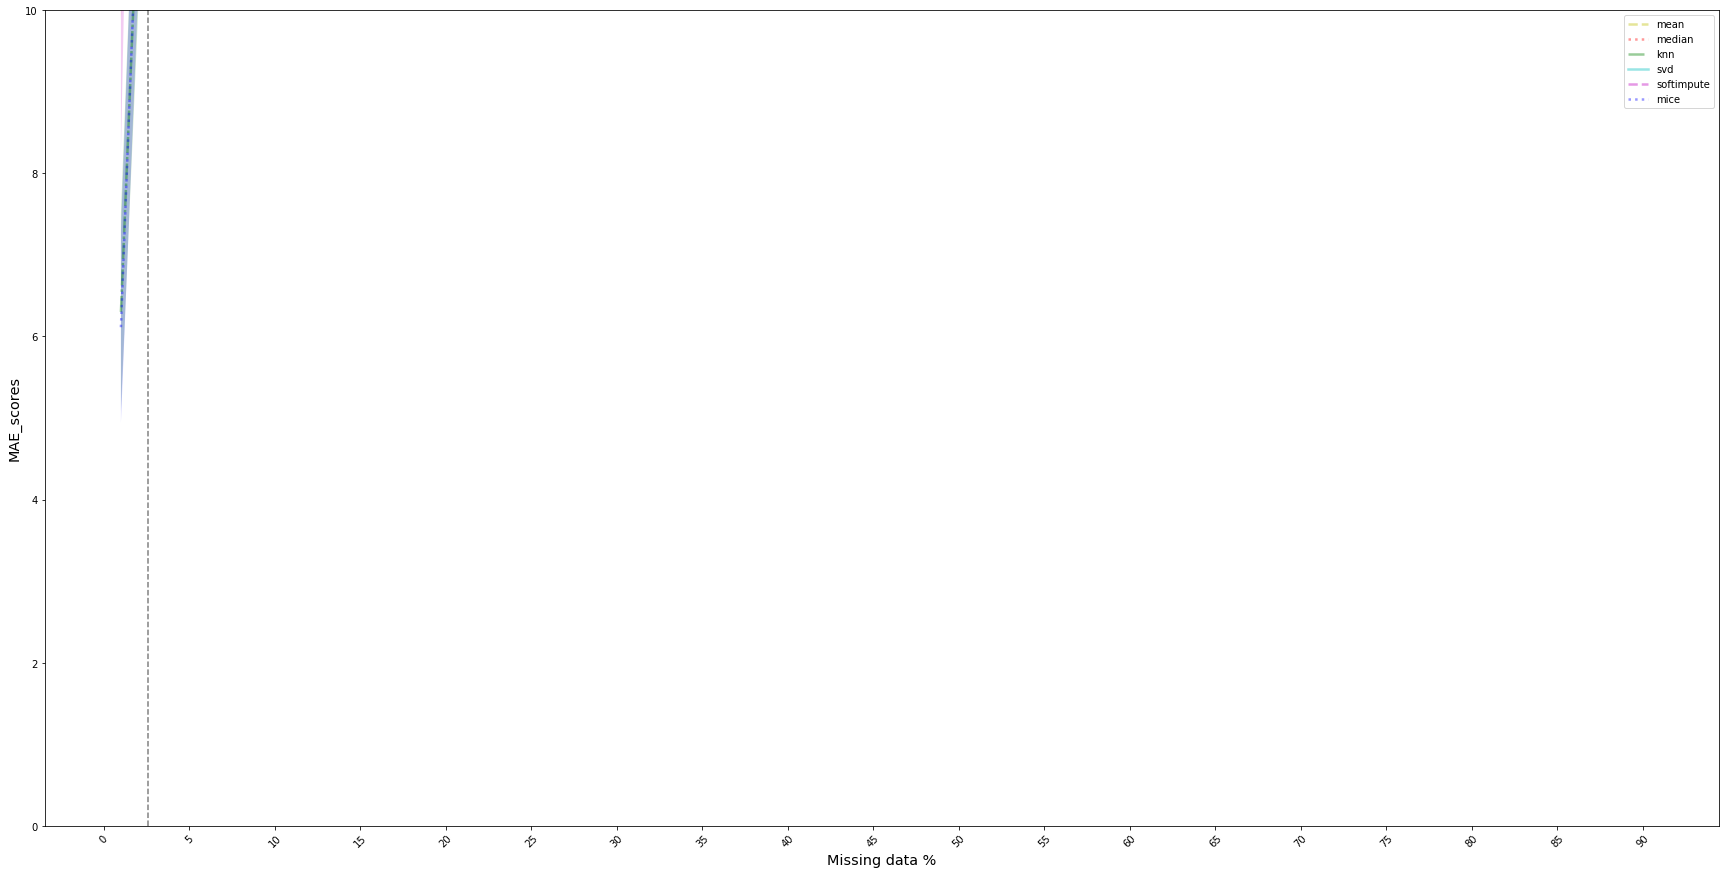

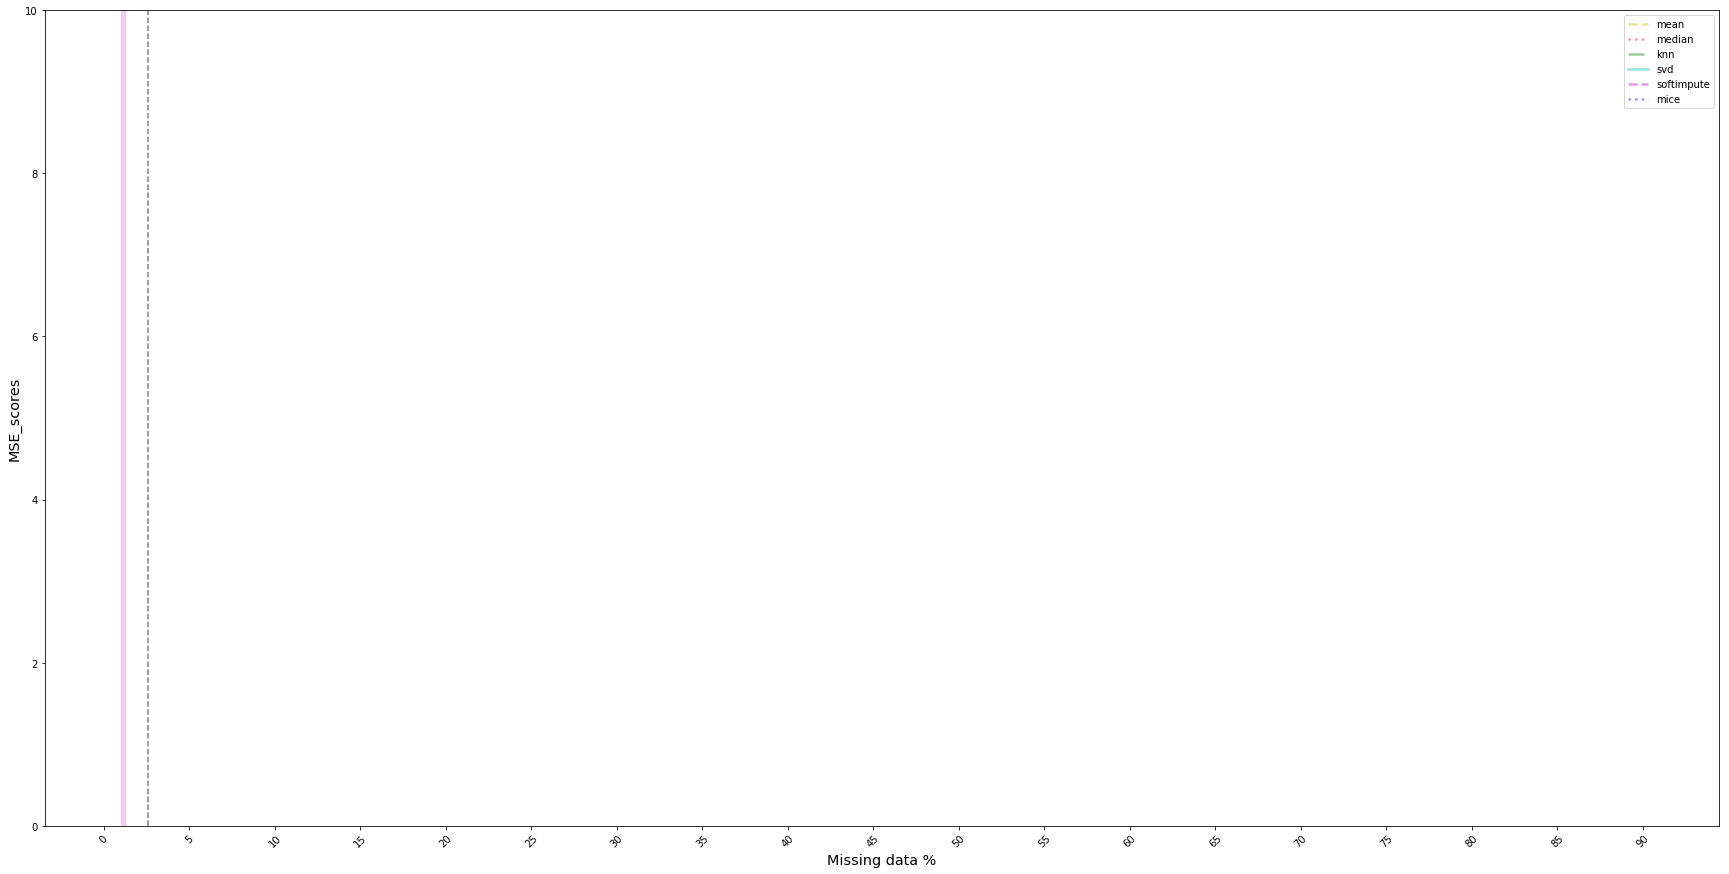

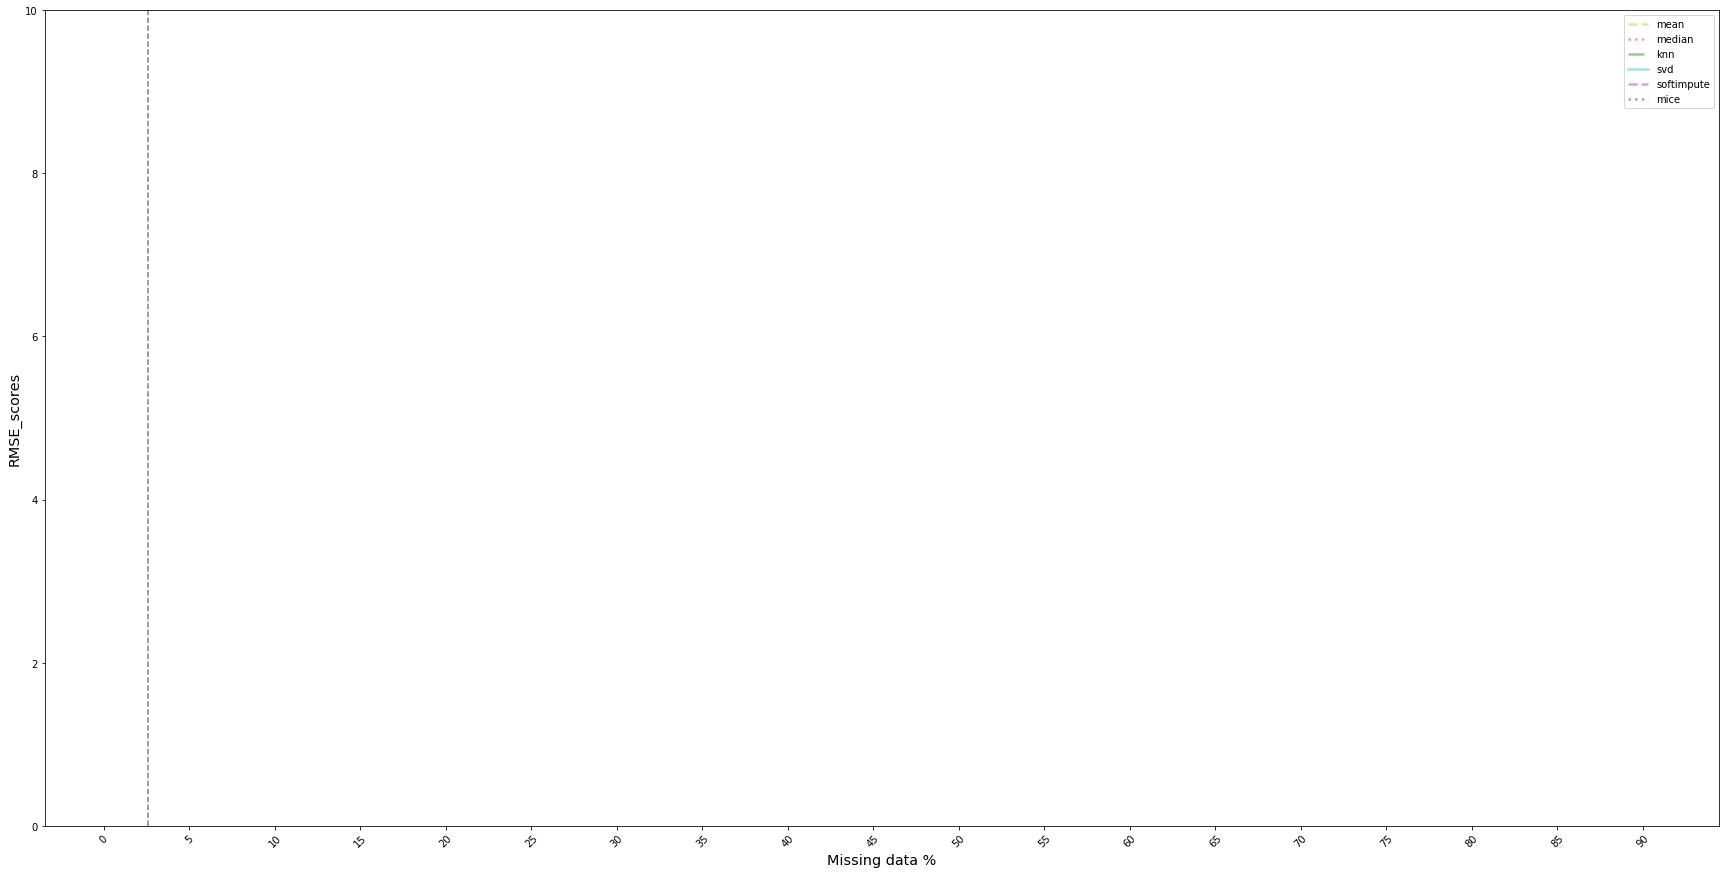

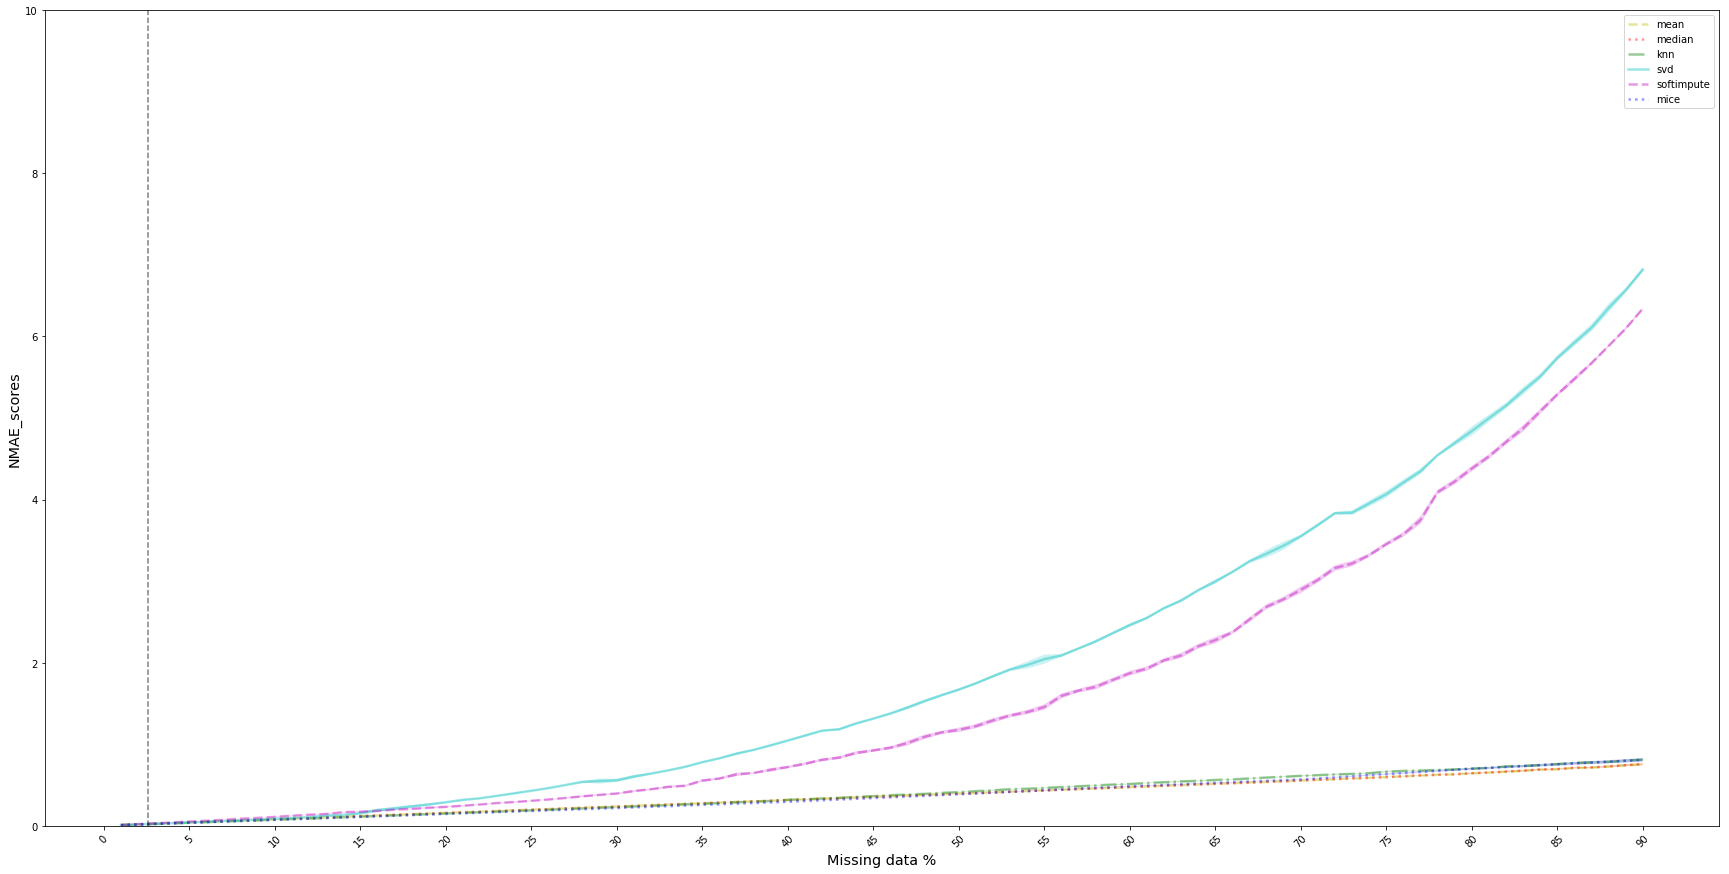

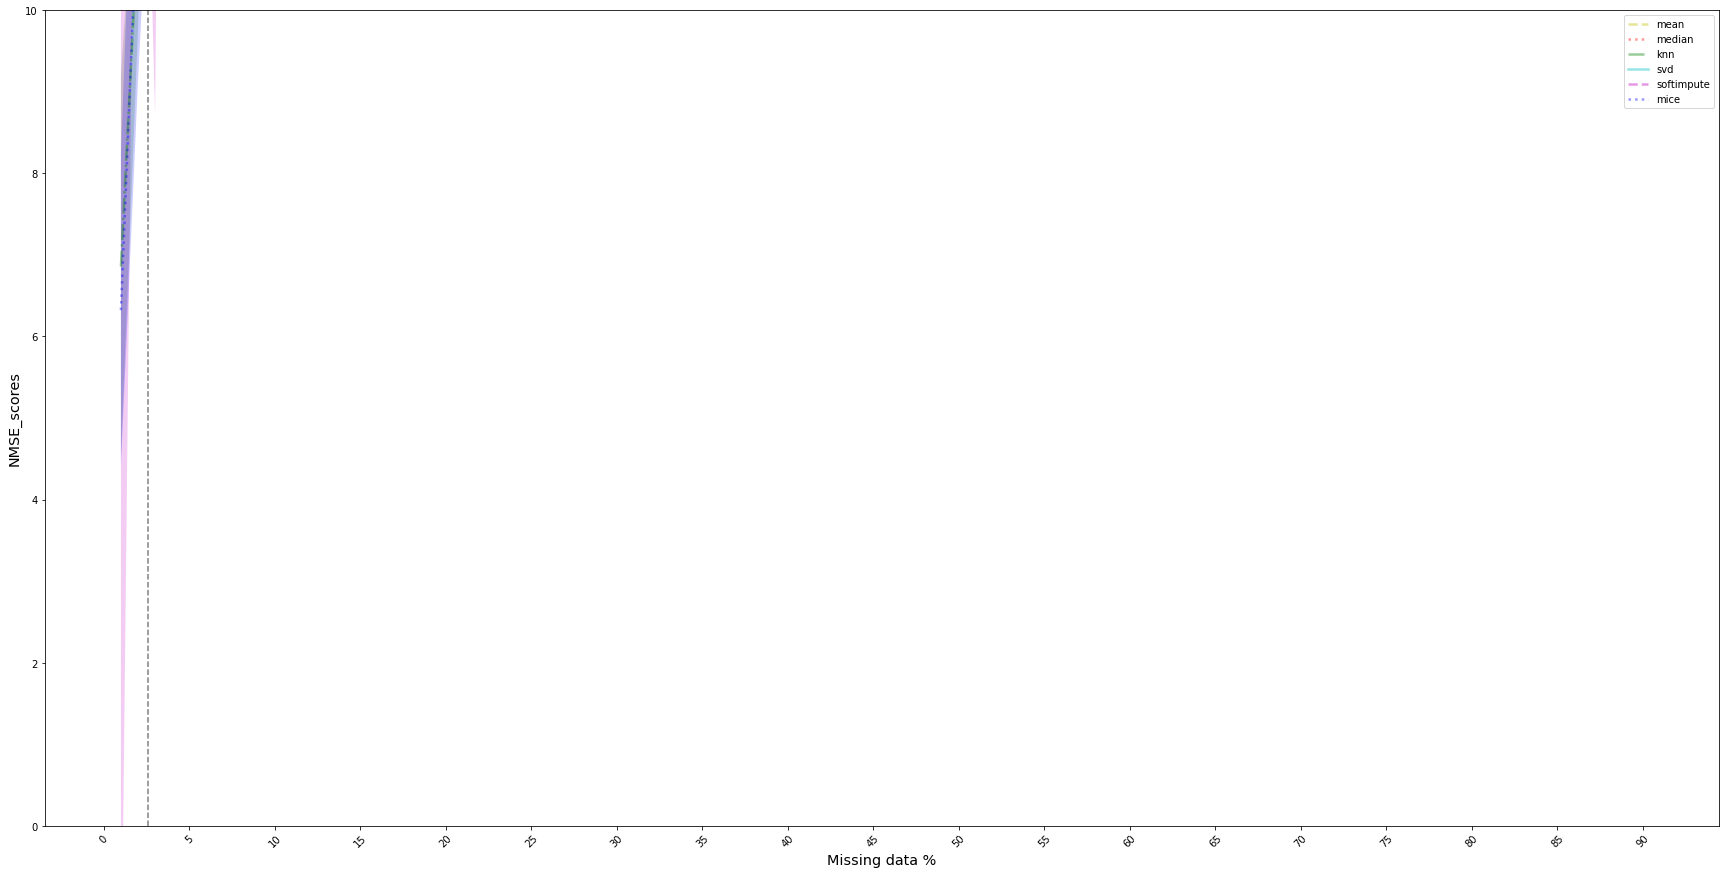

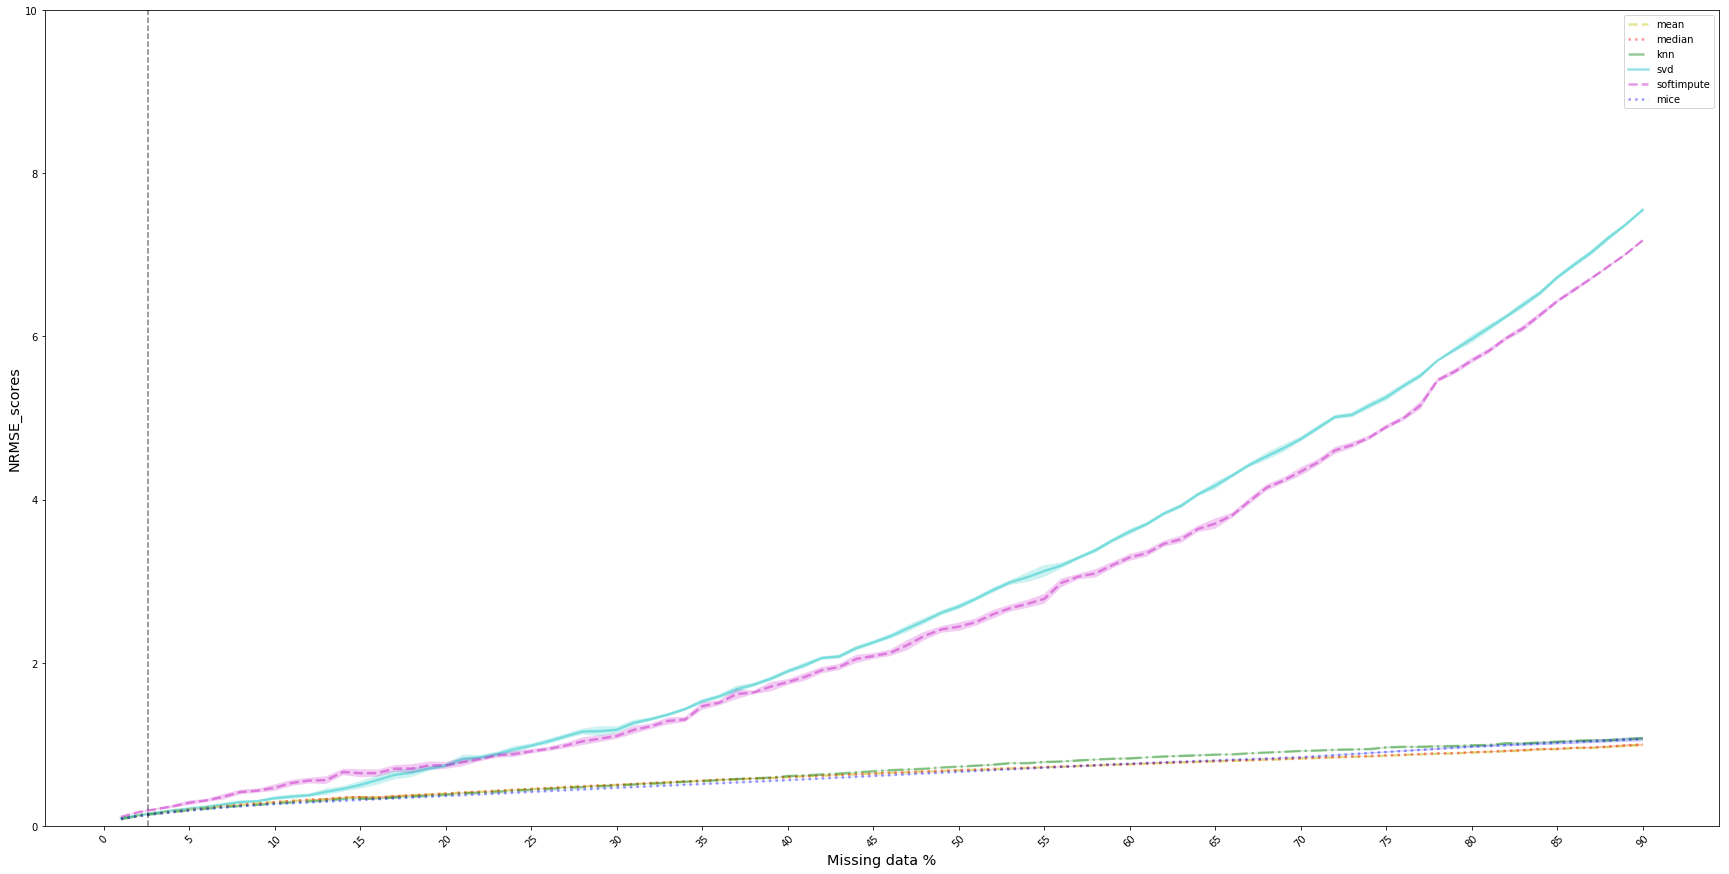

In [275]:
for i_m, metric_label in enumerate(metric_labels):
    
    strategies = ['mean', 'median', 'regression', 'knn', 'svd', 'softimpute', 'mice']
    score = all_scores[:, :, :, i_m]
    
    # Remove regression imputation as this will be replaced later with MICE!
    score = np.delete(score, [2], axis=-1)
    strategies = strategies[:2] + strategies[3:]    
    
    plot_results(fracs, strategies, score, metric_label, missing_data_percentage)

In [137]:
print all_scores[:, :, :, 5].shape
print all_scores[:, :, :, 5].mean(axis=1).shape

(90, 100, 7)
(90, 7)


In [138]:
tmp = all_scores[:, :, :, 5].mean(axis=1)
tmp[:, 2] = np.nan

In [139]:
np.nanargmin(tmp, axis=1)

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 6, 0, 3, 3, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [140]:
np.array(['mean', 'median', 'regression', 'knn', 'svd', 'softimpute', 'mice'])[np.nanargmin(tmp, axis=1)]

array(['mice', 'mice', 'mice', 'mice', 'mice', 'mice', 'mice', 'mice',
       'mice', 'mice', 'knn', 'knn', 'knn', 'knn', 'knn', 'knn', 'knn',
       'knn', 'knn', 'mice', 'knn', 'knn', 'knn', 'knn', 'knn', 'knn',
       'knn', 'knn', 'knn', 'mice', 'mean', 'knn', 'knn', 'mean', 'mean',
       'mean', 'mean', 'mean', 'mean', 'mice', 'mean', 'mean', 'mean',
       'mean', 'mean', 'mean', 'mean', 'mean', 'mean', 'mice', 'mean',
       'mean', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean',
       'mice', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean',
       'mean', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean',
       'mean', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean',
       'mean', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean'],
      dtype='|S10')

In [215]:
subcort_ICV_nan_idx = set(np.where(np.isnan(ENIGMA_OCD_df.subcort_ICV.values))[0])
print len(subcort_ICV_nan_idx)

110


In [216]:
cort_ICV_nan_idx = set(np.where(np.isnan(ENIGMA_OCD_df.cort_ICV.values))[0])
print len(cort_ICV_nan_idx)

223


In [229]:
has_no_icv = subcort_ICV_nan_idx.intersection(cort_ICV_nan_idx)
print subcort_ICV_nan_idx.intersection(cort_ICV_nan_idx)
print len(subcort_ICV_nan_idx.intersection(cort_ICV_nan_idx))
print cort_ICV_nan_idx.intersection(subcort_ICV_nan_idx) == subcort_ICV_nan_idx.intersection(cort_ICV_nan_idx)

set([2473, 611, 4324, 4294, 2684, 971, 3021, 3695, 3028, 1046, 1769, 2557, 2716, 1789, 1791])
15
True


In [151]:
bool_nans = bool_nan_ind_container[-1, -1]
X_c_tot.shape

(2012, 160)

In [228]:
#TODO check the rows which have a NaN in avg_ICV... we should drop these. 
# but do they miss only ICV or (hopefully) a lot more?
ENIGMA_OCD_df[(ENIGMA_OCD_df.subcort_ICV.isnull()) & (ENIGMA_OCD_df.cort_ICV.isnull())]

age_group tesla       site      Age   Dx  \
SubjID                                                                      
subj78                             1_adult  1.5t  Buitelaar   8.7586  1.0   
subj0036                           1_adult  1.5t    Nakamae      NaN  NaN   
subj0001                           1_adult  1.5t    Nakamae      NaN  NaN   
AOCD_041-1GB                       1_adult    3t      Nurmi  25.0000  0.0   
AOCD_033-1                         1_adult    3t      Nurmi      NaN  NaN   
AOCD_041-1                         1_adult    3t      Nurmi      NaN  NaN   
NaN                                1_adult    3t    Brennan      NaN  NaN   
fMRI004                            1_adult    3t    Brennan  46.0000  0.0   
subj03                             1_adult    3t       Wang      NaN  NaN   
subj23                             1_adult    3t       Wang      NaN  NaN   
subj35                             1_adult    3t      Stein  43.0000  0.0   
subj38                             1_adult    3t      Stein      NaN  NaN   
P1108-1                        2_pediatric    3t      Nurmi  13.0000  1.0   
14.0                           2_pediatric    3t    Stewart  17.3600  1.0   
50                             2_pediatric    3t    Stewart      NaN  NaN   

                               Med  Sex  subcort_ICV  cort_ICV  LLatVent  \
SubjID                                                                     
subj78                         1.0  1.0          NaN       NaN       NaN   
subj0036                       NaN  NaN          NaN       NaN       NaN   
subj0001                       NaN  NaN          NaN       NaN       NaN   
AOCD_041-1GB                   0.0  2.0          NaN       NaN       NaN   
AOCD_033-1                     NaN  NaN          NaN       NaN    5996.1   
AOCD_041-1                     NaN  NaN          NaN       NaN    4482.8   
NaN                            NaN  NaN          NaN       NaN       NaN   
fMRI004                        0.0  1.0          NaN       NaN       NaN   
subj03                         NaN  NaN          NaN       NaN       NaN   
subj23                         NaN  NaN          NaN       NaN   13479.5   
subj35                         0.0  2.0          NaN       NaN    5587.6   
subj38                         NaN  NaN          NaN       NaN    9052.4   
P1108-1                        2.0  2.0          NaN       NaN    6735.5   
14.0                           2.0  2.0          NaN       NaN       NaN   
50                             NaN  NaN          NaN       NaN       NaN   

                                       ...           R_precuneus_thickavg  \
SubjID                                 ...                                  
subj78                                 ...                            NaN   
subj0036                               ...                            NaN   
subj0001                               ...                            NaN   
AOCD_041-1GB                           ...                          2.092   
AOCD_033-1                             ...                            NaN   
AOCD_041-1                             ...                            NaN   
NaN                                    ...                            NaN   
fMRI004                                ...                            NaN   
subj03                                 ...                            NaN   
subj23                                 ...                            NaN   
subj35                                 ...                          2.444   
subj38                                 ...                            NaN   
P1108-1                                ...                          2.533   
14.0                                   ...                            NaN   
50                                     ...                            NaN   

                               R_rostralanteriorcingulate_thickavg  \
SubjID                                            

In [ ]:
bool_nans = bool_nan_ind_container[-1, 50]

In [272]:
bool_nan_ind_container.shape
scores = np.zeros(100)
i = 0

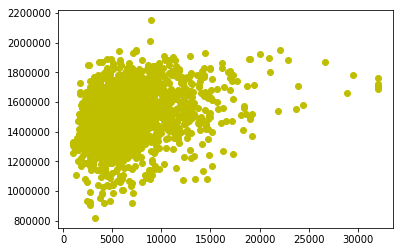

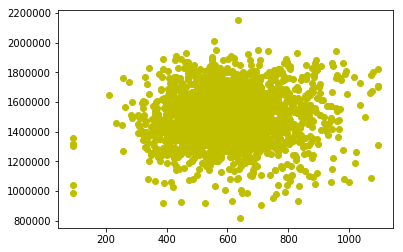

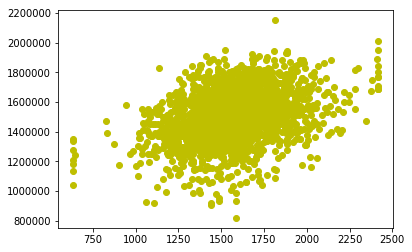

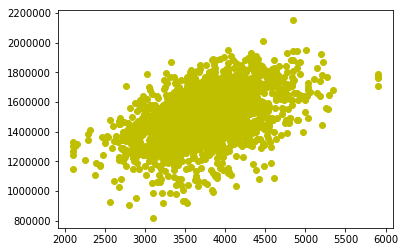

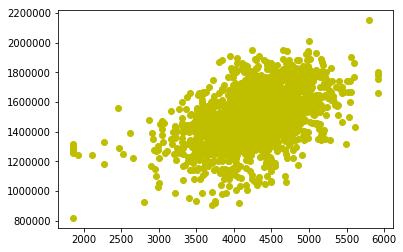

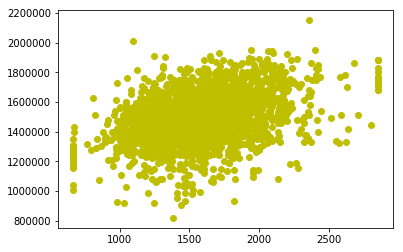

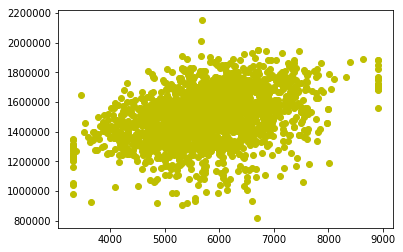

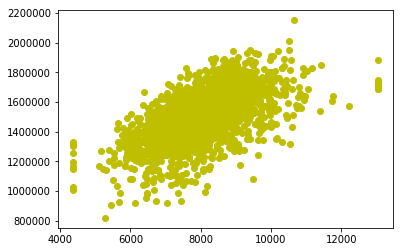

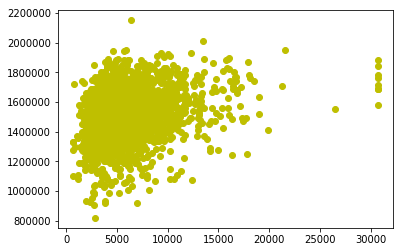

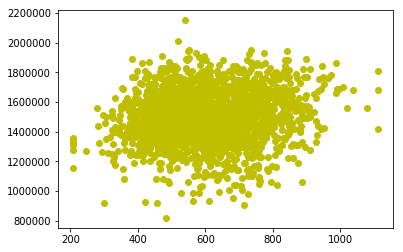

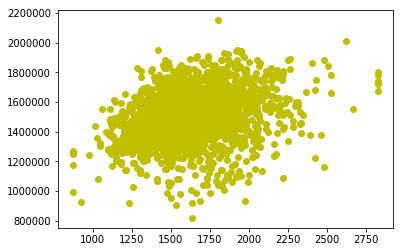

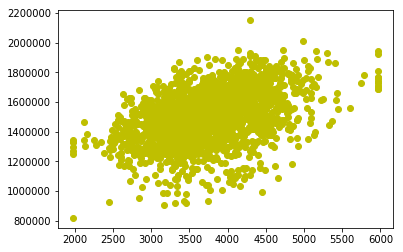

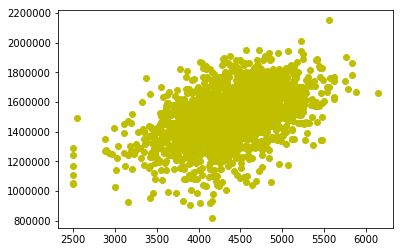

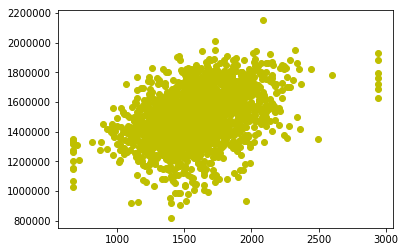

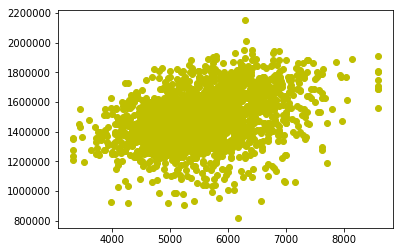

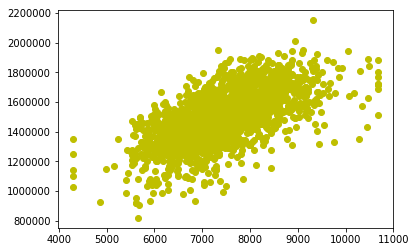

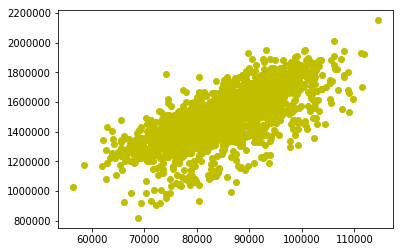

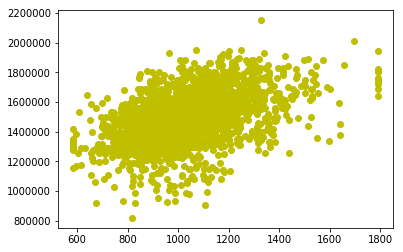

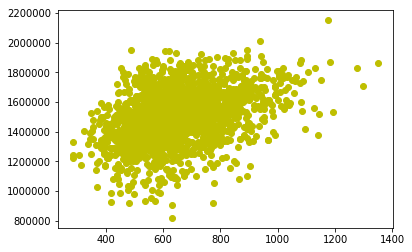

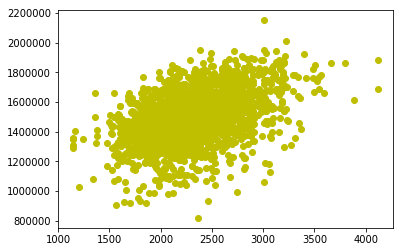

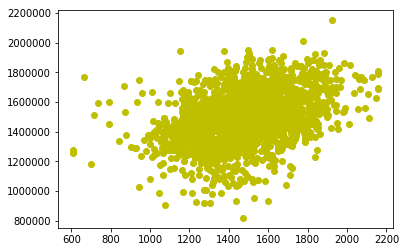

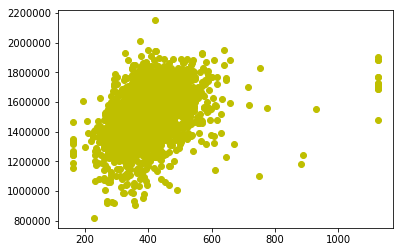

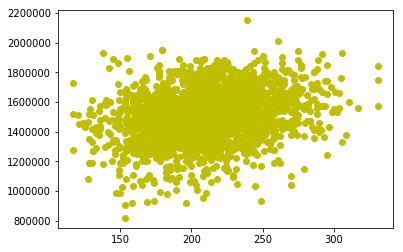

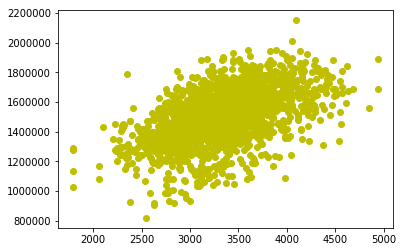

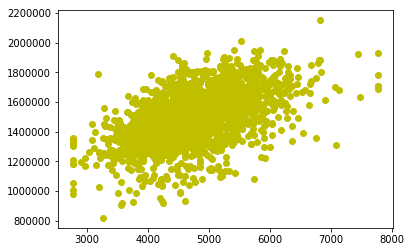

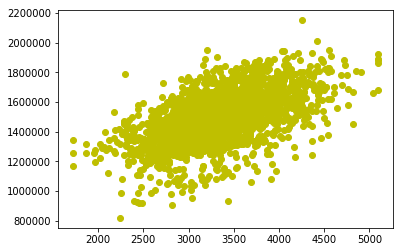

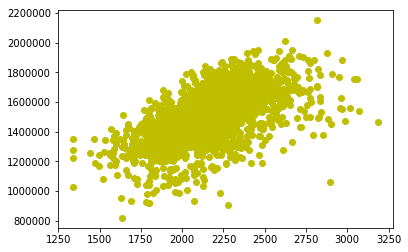

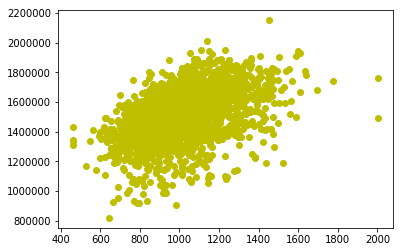

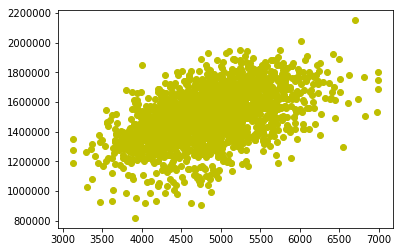

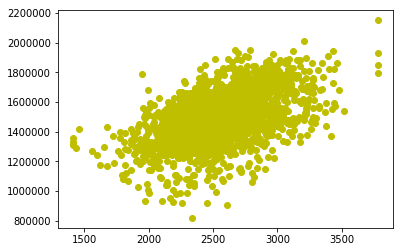

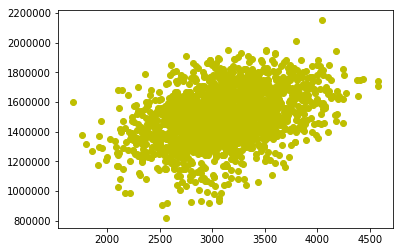

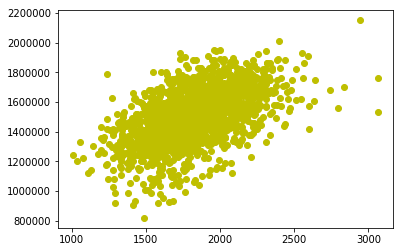

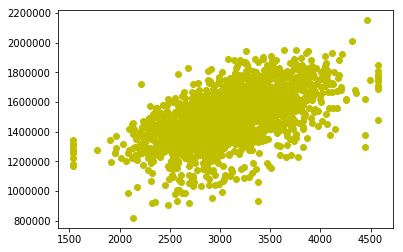

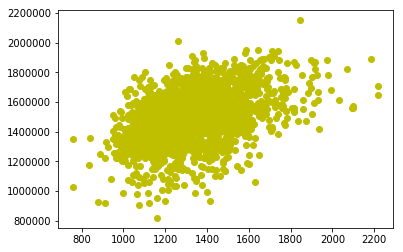

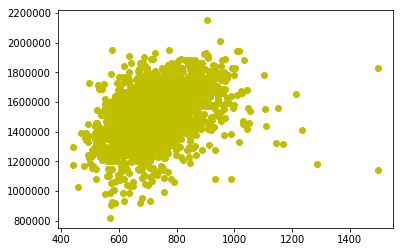

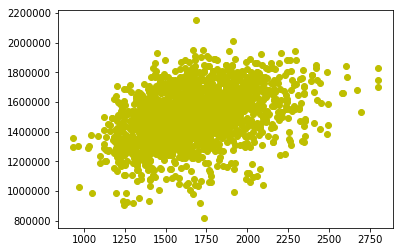

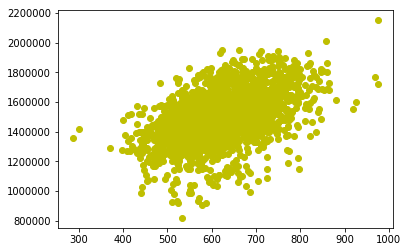

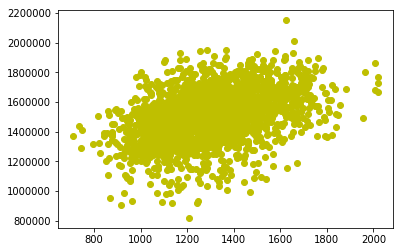

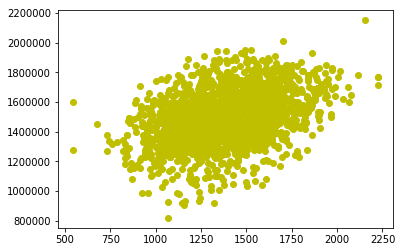

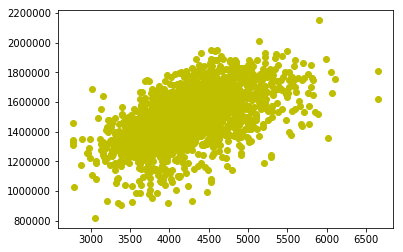

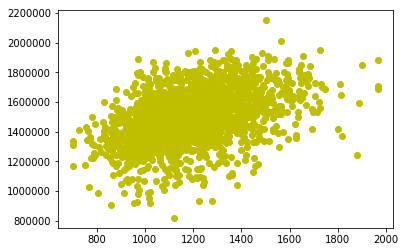

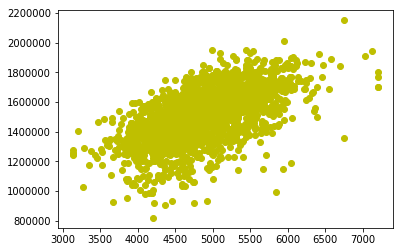

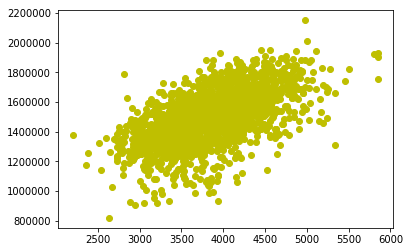

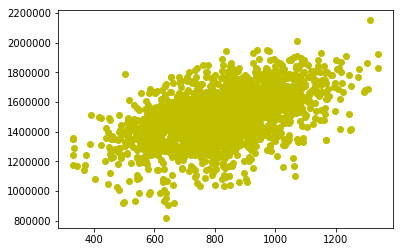

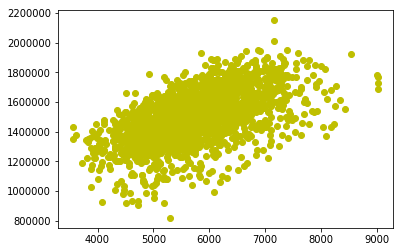

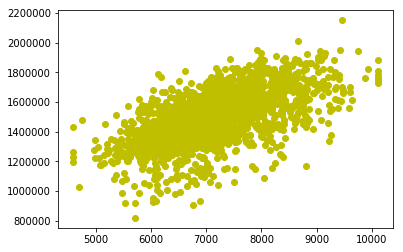

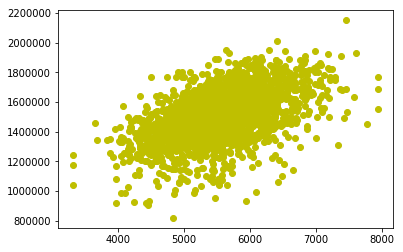

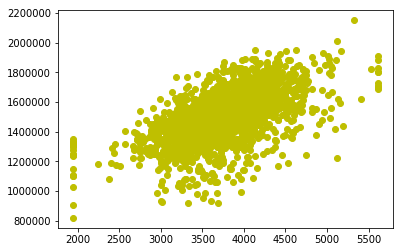

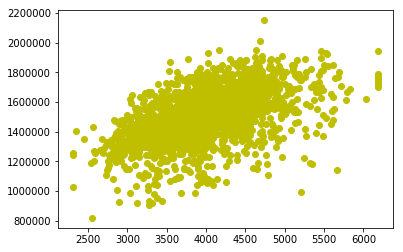

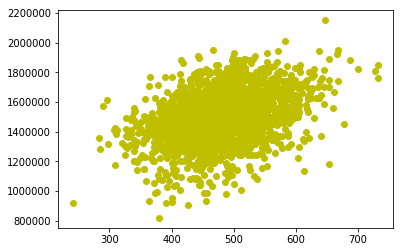

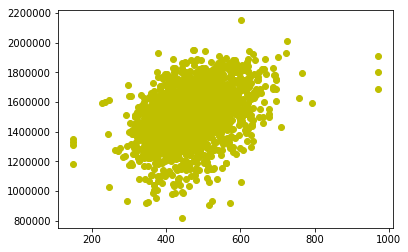

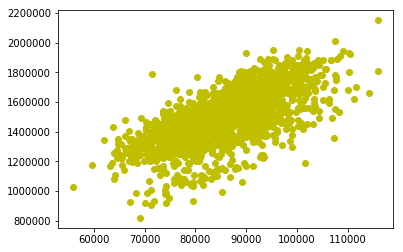

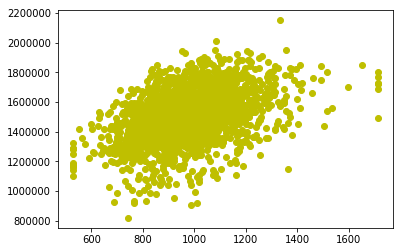

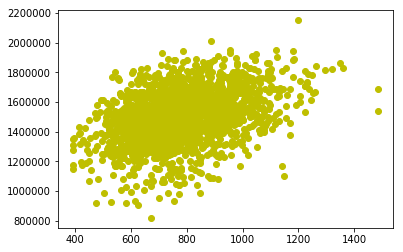

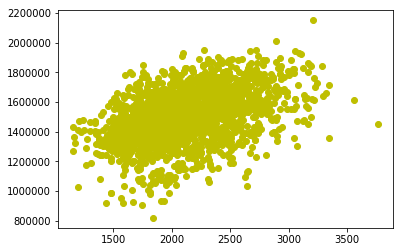

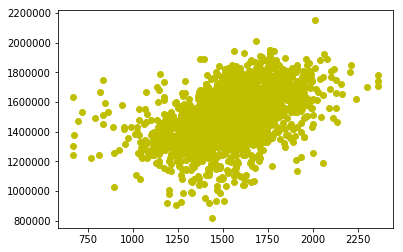

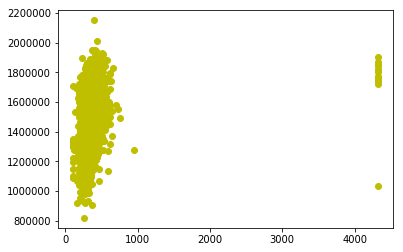

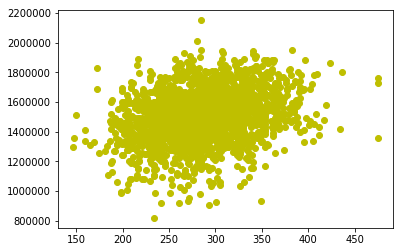

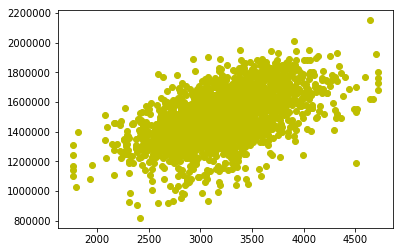

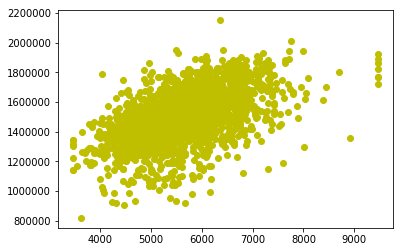

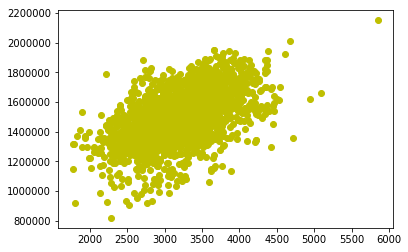

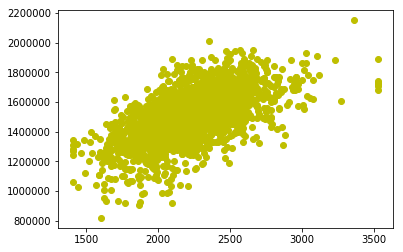

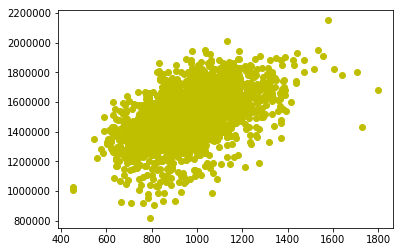

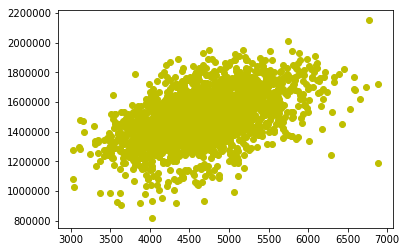

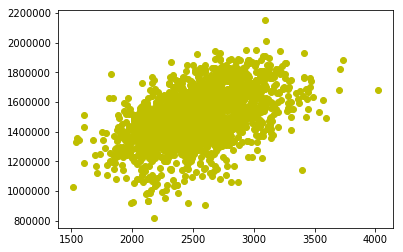

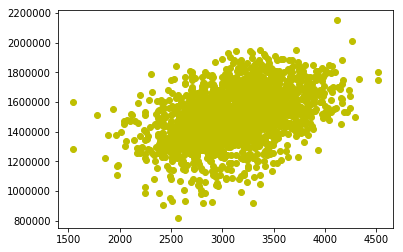

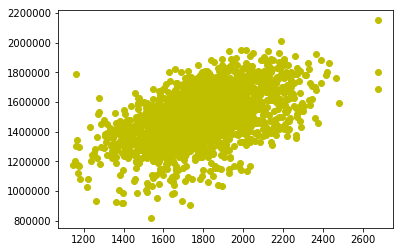

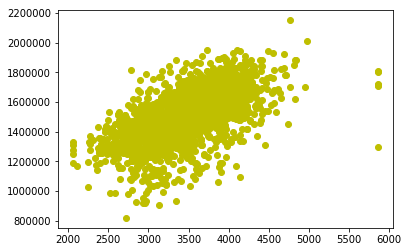

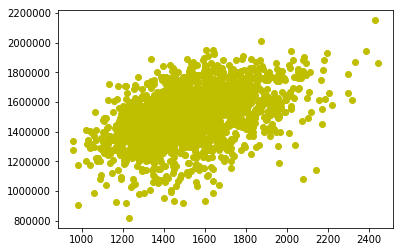

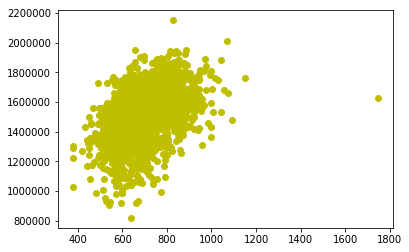

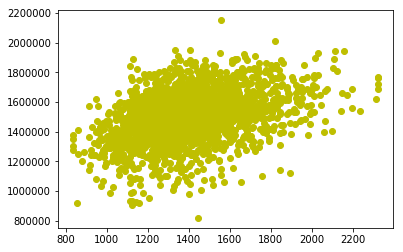

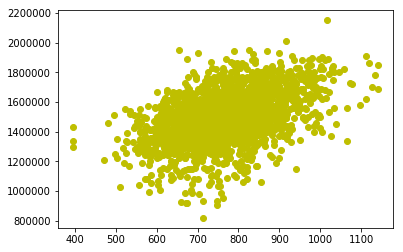

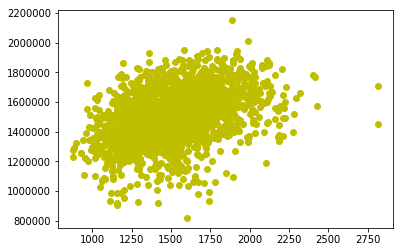

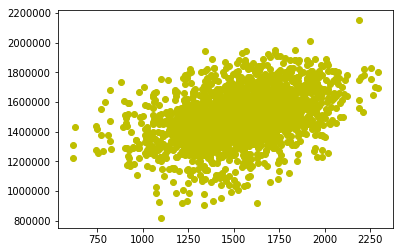

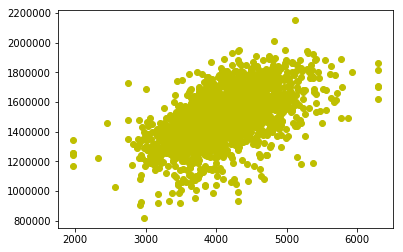

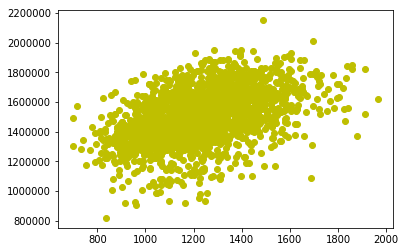

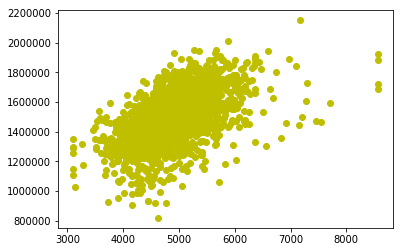

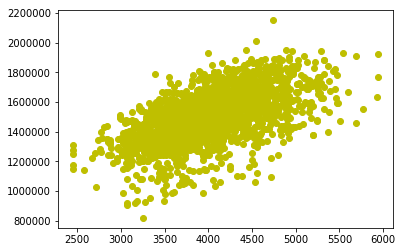

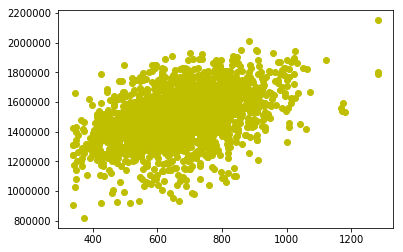

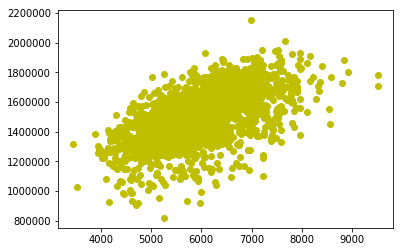

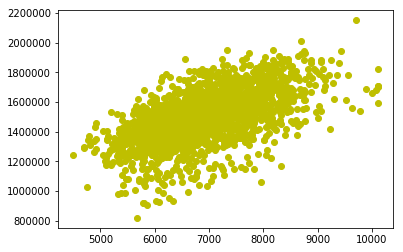

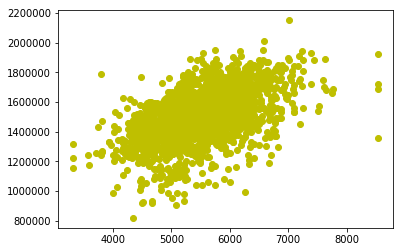

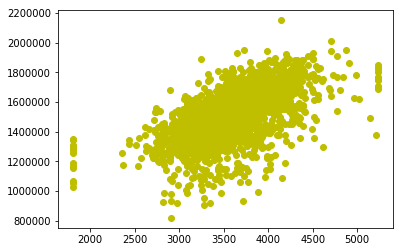

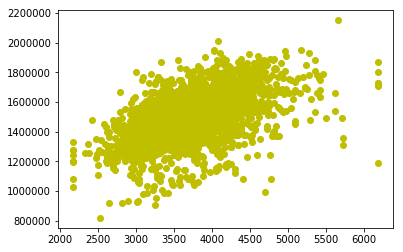

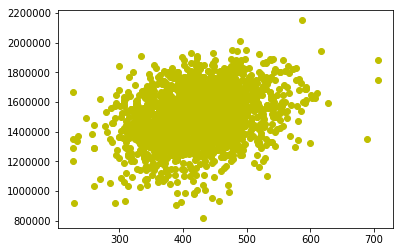

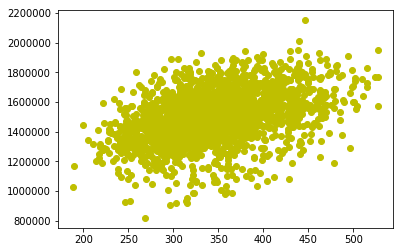

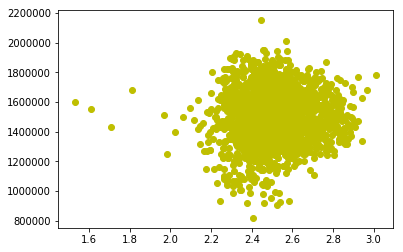

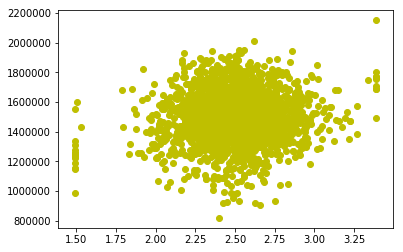

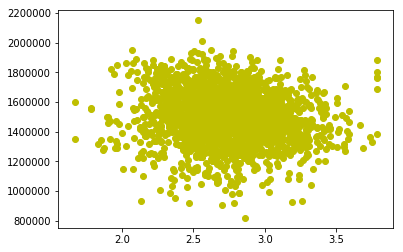

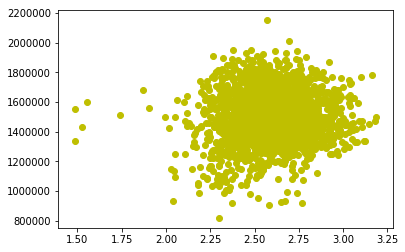

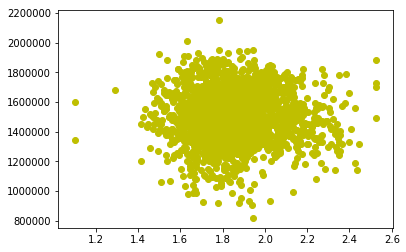

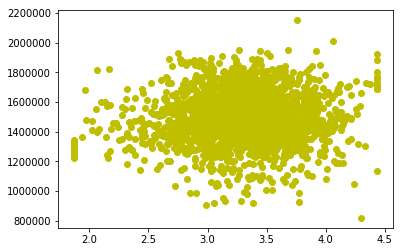

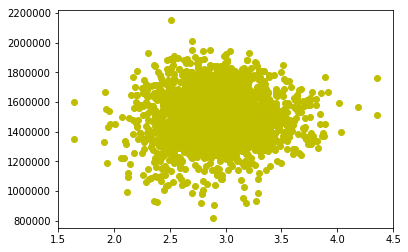

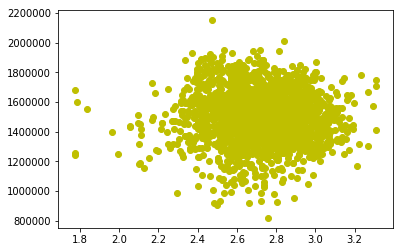

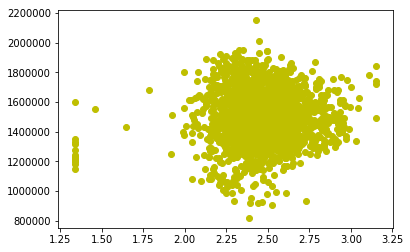

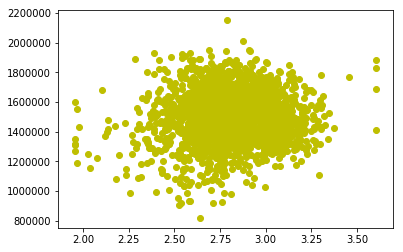

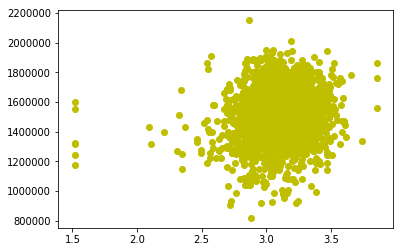

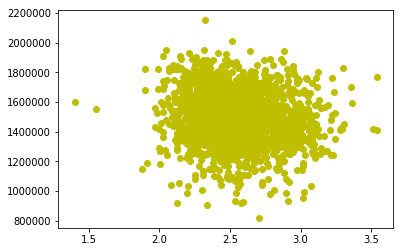

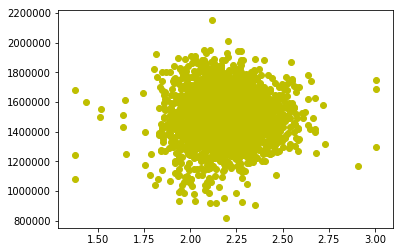

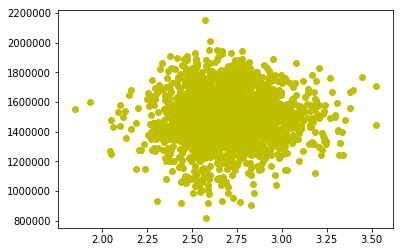

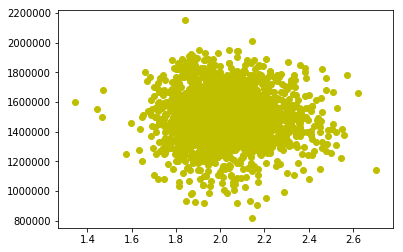

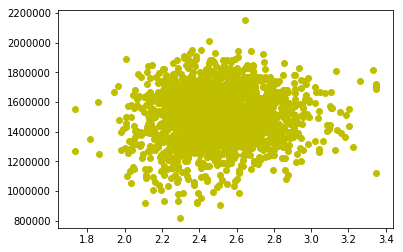

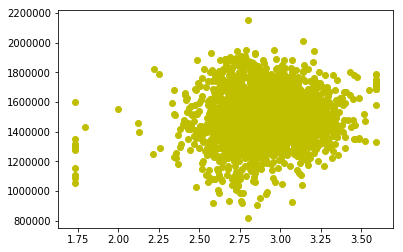

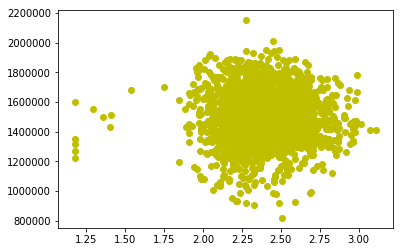

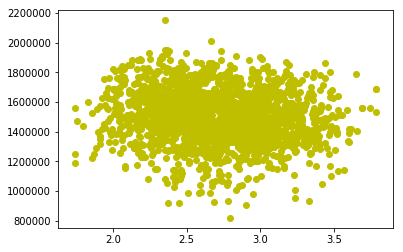

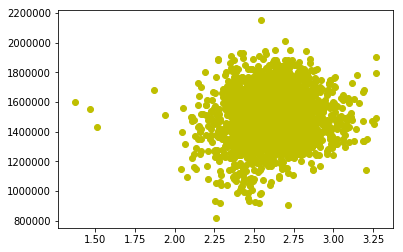

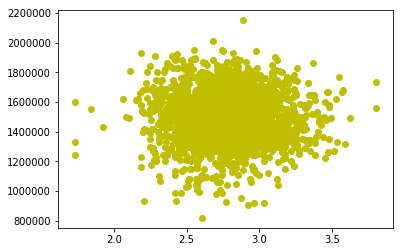

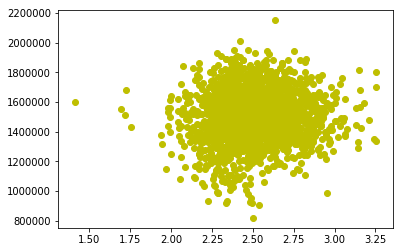

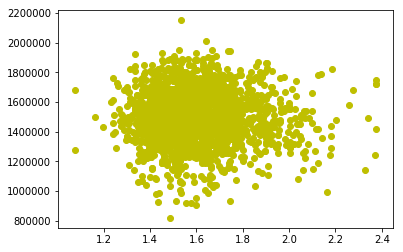

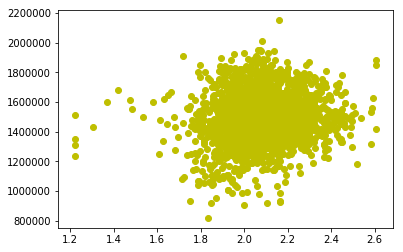

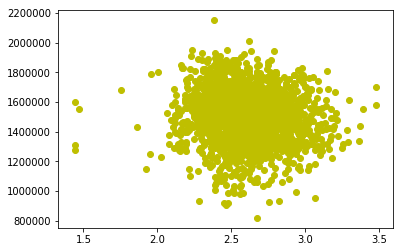

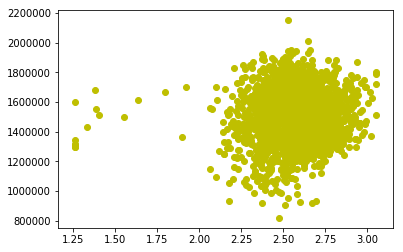

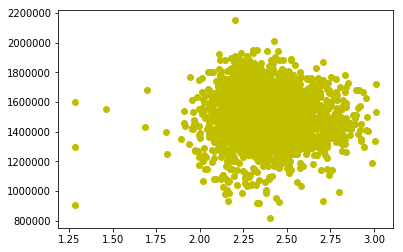

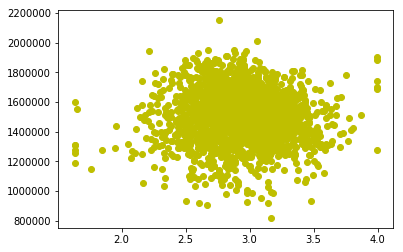

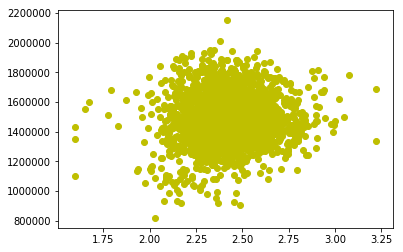

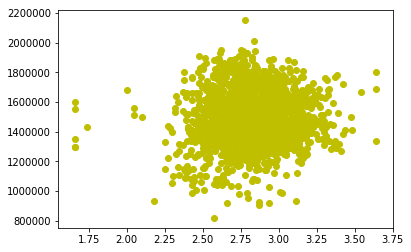

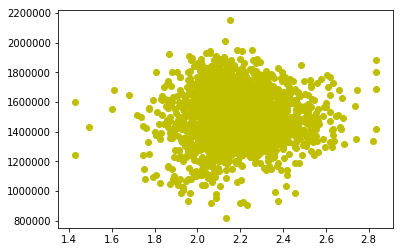

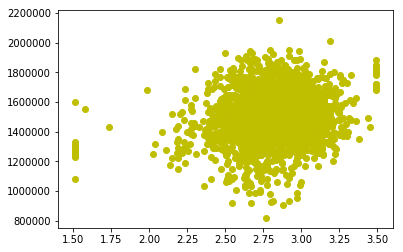

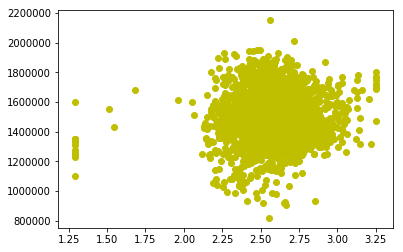

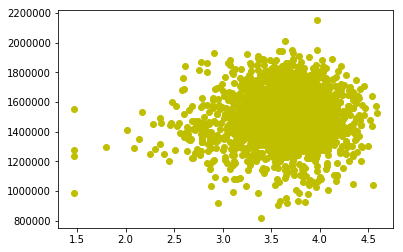

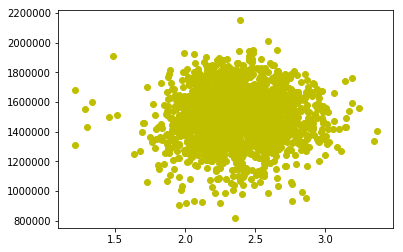

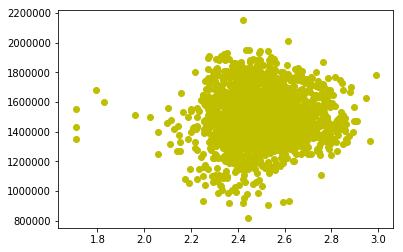

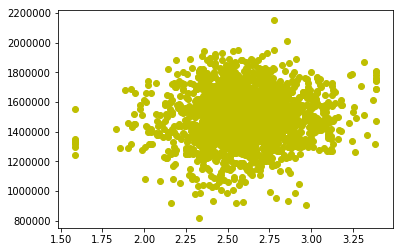

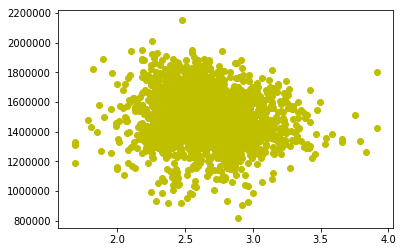

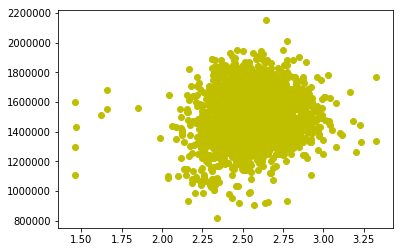

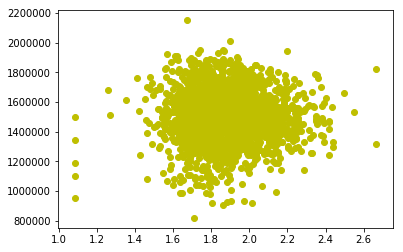

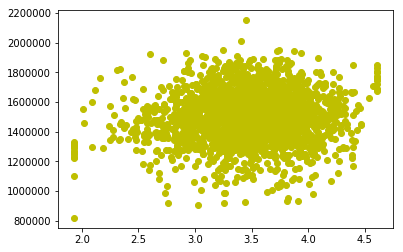

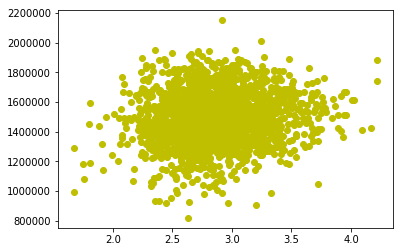

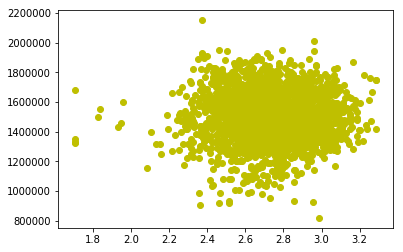

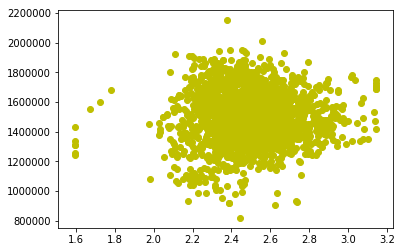

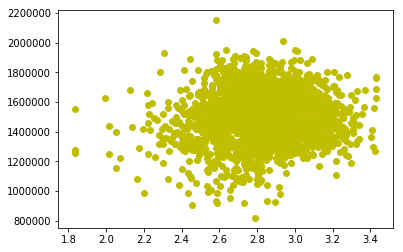

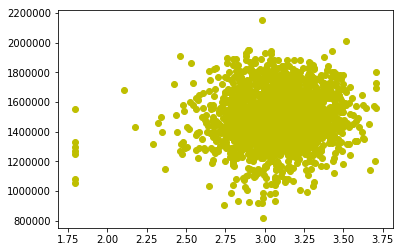

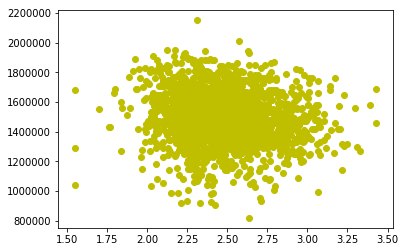

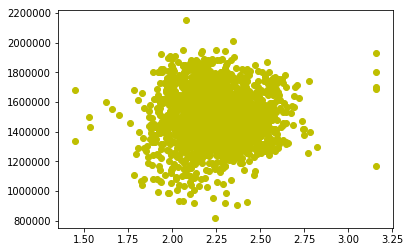

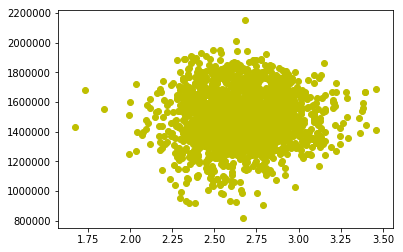

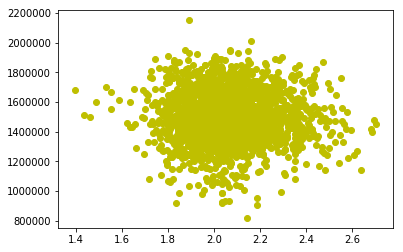

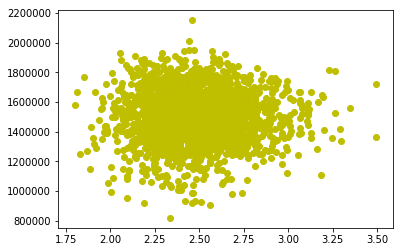

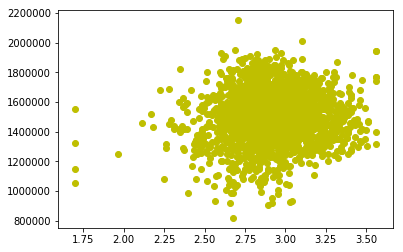

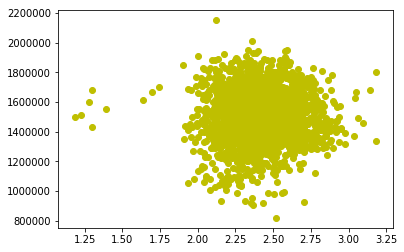

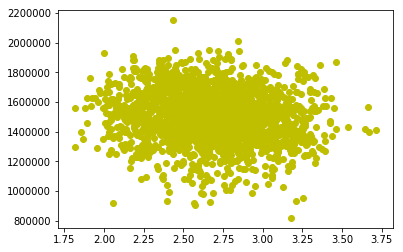

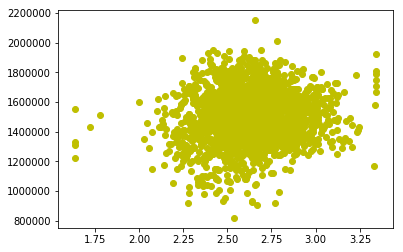

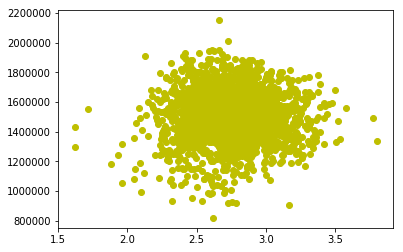

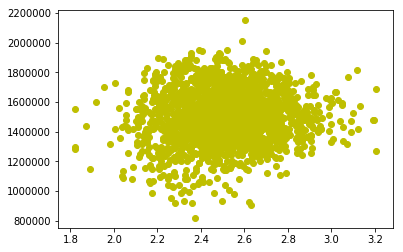

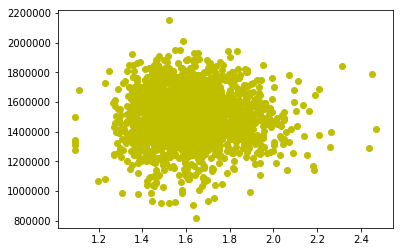

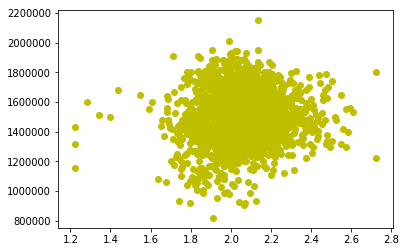

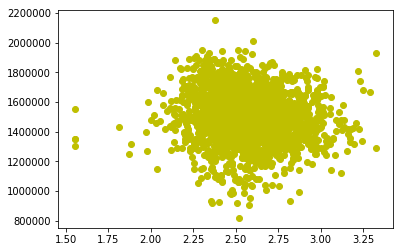

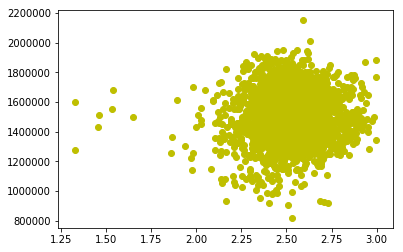

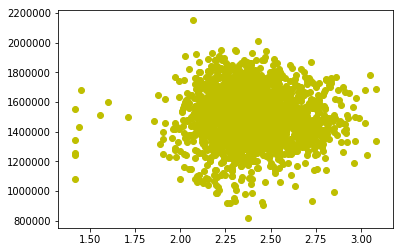

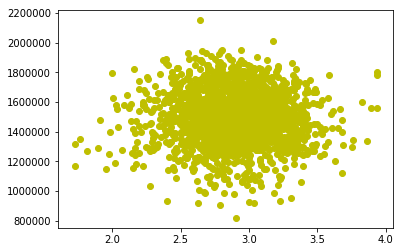

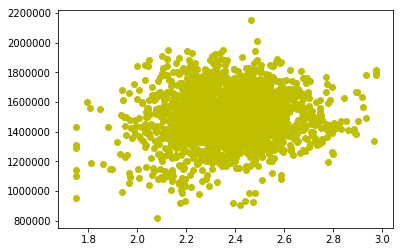

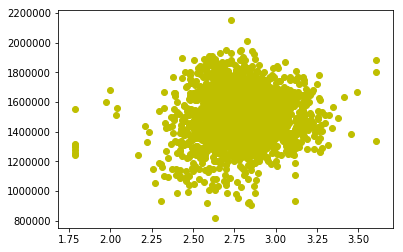

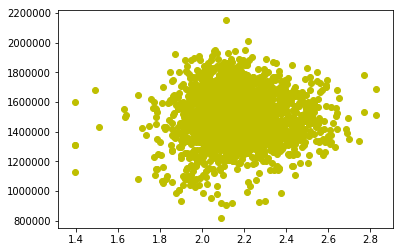

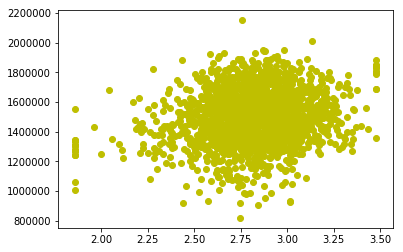

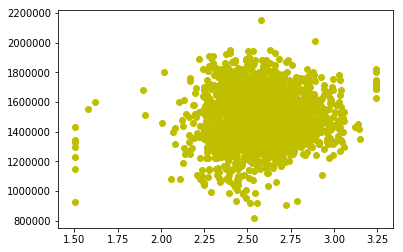

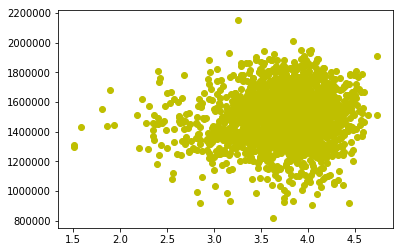

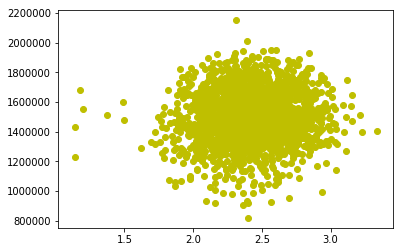

In [326]:
for i in np.arange(4, X.shape[1]):
    plt.scatter(X[:, i], avg_ICV)
    plt.show()

In [273]:
for bool_nans in bool_nan_ind_container[0, :]:

    # X will be passed to this function
    X = X_without_NaNs.copy()
    X[bool_nans] = np.nan

    # Find the column indices belonging to (sub)cortical ICV features
    cort_icv = np.where(columns_to_choose == "cort_ICV")[0][0]
    subcort_icv = np.where(columns_to_choose == "subcort_ICV")[0][0]

    # Calculate average ICV
    avg_ICV = np.nanmean(X[:, [cort_icv, subcort_icv]], axis=1)

    n_subjects = float(len(avg_ICV))

    # Find indices for rows and columns with missing values
    r, c = np.where(np.isnan(X))

    rows_with_nan, rows_index, rows_counts = np.unique(r, return_index=True, return_counts=True)

    # Iterate over missing values
    for row, idx, counts in zip(rows_with_nan, rows_index, rows_counts):

        icv = avg_ICV[row]
        missing_columns = c[idx:idx+counts]

        # If no ICV available is for this subject use simple mean imputation
        if icv == np.nan:
             for column_index in range(len(missing_columns)):
                    missing_column = missing_columns[column_index] 
                    X[row, missing_column] = np.nanmean(X[column_index])

        # Calculate percentile for ICV belonging to this subject
        percentile = int(np.searchsorted(avg_ICV, icv) / n_subjects * 100)

        for column_index in range(len(missing_columns)):         
                missing_column = missing_columns[column_index] 
                X[row, missing_column] = np.nanpercentile(X[:, missing_column], percentile)      
                  
    X_true_test_masked, X_mean_imp_test_masked = X_without_NaNs.copy(), X.copy()
    X_true_test_masked[~bool_nans], X_mean_imp_test_masked[~bool_nans] = np.nan, np.nan

    MSE_per_column = np.nanmean(((X_true_test_masked - X_mean_imp_test_masked) ** 2), axis=0) 
    RMSE_per_column = np.sqrt(MSE_per_column)  

    score = np.nanmean(RMSE_per_column / np.nanstd(X_without_NaNs, axis=0))
    scores[i] = score
    i = i + 1

/data/wbbruin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: Mean of empty slice
/data/wbbruin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: Mean of empty slice


In [274]:
scores

array([ 2.44662615,  2.44662615,  2.44662615,  2.44662615,  2.44662615,
        2.44662615,  2.44662615,  2.44662615,  2.44662615,  2.44662615,
        2.52275574,  2.52275574,  2.52275574,  2.49992216,  2.49992216,
        2.49992216,  2.37935278,  2.52275574,  2.52275574,  2.52275574,
        2.52275574,  2.52275574,  2.52275574,  2.37935278,  2.37935278,
        2.33077313,  2.49992216,  2.49992216,  2.52275574,  2.49992216,
        2.49992216,  2.33077313,  2.37656622,  2.49992216,  2.33077313,
        2.49992216,  2.37935278,  2.37935278,  2.49992216,  2.37935278,
        2.37656622,  2.37935278,  2.45963121,  2.37656622,  2.33077313,
        2.37935278,  2.33077313,  2.37935278,  2.45963121,  2.33077313,
        2.3991304 ,  2.33077313,  2.37935278,  2.45963121,  2.37656622,
        2.37656622,  2.33077313,  2.33077313,  2.39980529,  2.33077313,
        2.37656622,  2.3991304 ,  2.37656622,  2.45963121,  2.37656622,
        2.45963121,  2.37656622,  2.3991304 ,  2.42816485,  2.45

In [269]:
X_true_test_masked, X_mean_imp_test_masked = X_without_NaNs.copy(), X.copy()
X_true_test_masked[~bool_nans], X_mean_imp_test_masked[~bool_nans] = np.nan, np.nan

MSE_per_column = np.nanmean(((X_true_test_masked - X_mean_imp_test_masked) ** 2), axis=0) 
RMSE_per_column = np.sqrt(MSE_per_column)  

print np.nanmean(RMSE_per_column / np.nanstd(X_without_NaNs, axis=0))

1.95460341942


/data/wbbruin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


In [288]:
nans_per_column = np.isnan(X_tot).sum(axis=0)
print nans_per_column

[  0   0 101  15 113 157 231 180 189 499 415 315 111 153 221 208 158 271
 206 195  12 403  85  47  86 330  25  51 196 113  92  33  62  20  37  40
 305  32  54  44  31  27  67 113  33  90  34  84  36 120  72 397 335  31
  25  13 290  65  53  87 488  22  75 148  74  98  31  57  21  23  46 112
  25  60  64  24  69  67  93  35 114  32  83  38  84  77 310 290  63  20
  12 399  85  47  85 329  25  51 195 112  95  33  62  20  36  40 304  32
  53  44  31  27  67 112  32  90  34  85  36 120  72 392 333  30  25  17
 286  65  52  87 486  22  75 145  74 102  30  57  21  22  46 111  25  59
  64  24  69  66  90  35 112  32  83  38  84  77 300 280  63  20]


In [287]:
sorted_indices = np.argsort(nans_per_column)[::-1]

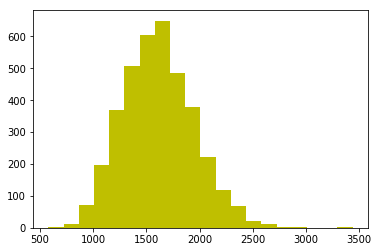

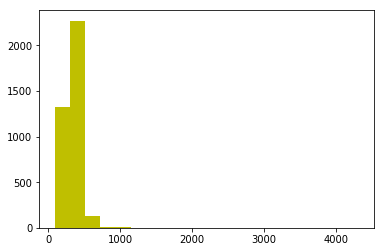

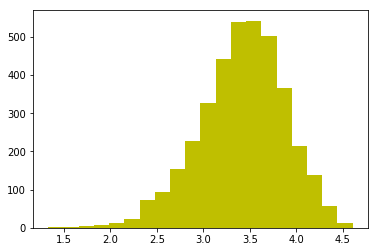

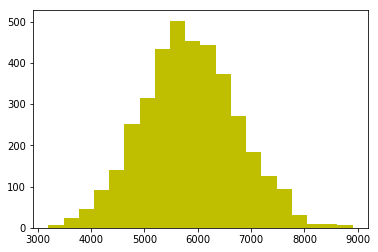

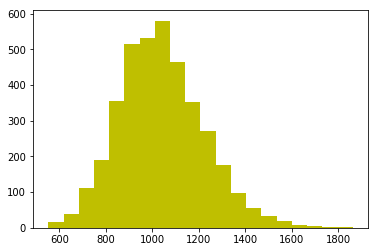

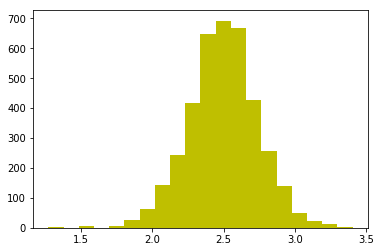

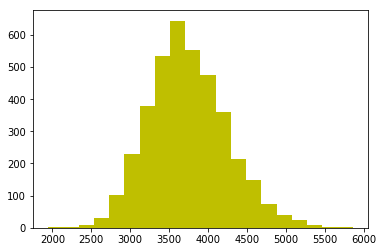

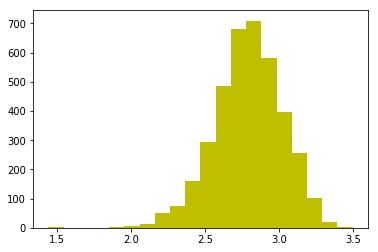

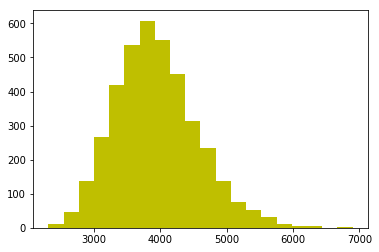

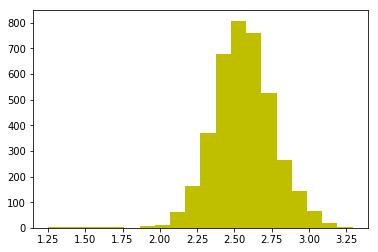

In [296]:
for s_i in sorted_indices[:10]:
    column_with_nans = X_tot[:, s_i]
    column_without_nans = column_with_nans[np.isfinite(column_with_nans)]
    plt.hist(column_without_nans, bins=20)
    plt.show()

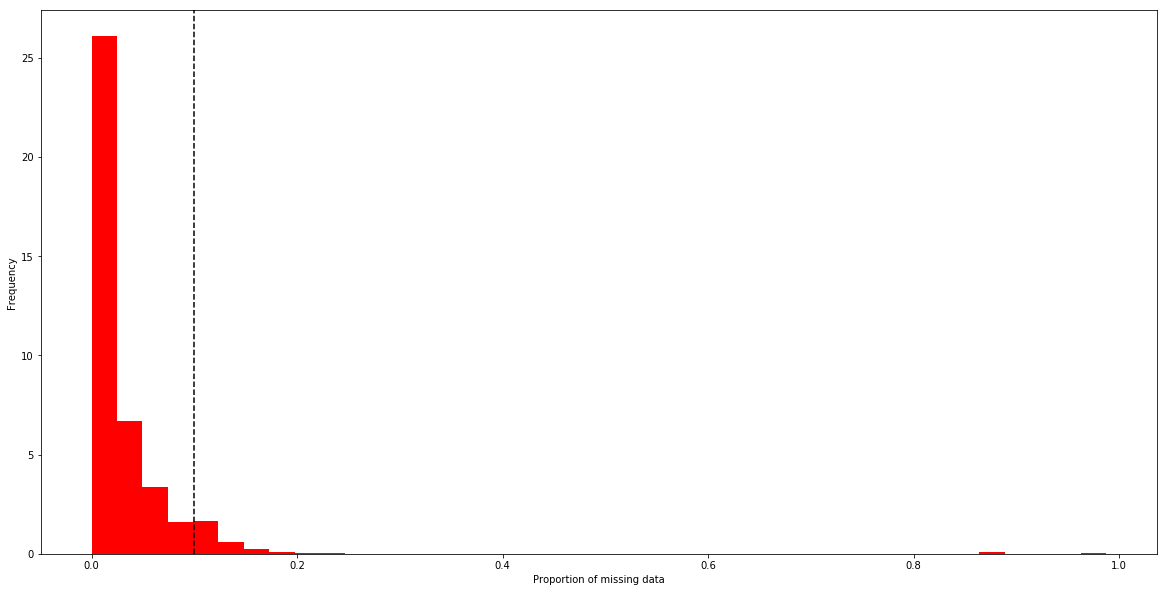

In [361]:
nans_per_subject = np.isnan(X_tot).sum(axis=1)
nans_per_subject_p = nans_per_subject / float(160)

plt.figure(figsize=(20,10))
plt.hist(nans_per_subject_p, bins=40, color='r', normed=1)
plt.axvline(x=0.1, color='black', linestyle='--')
plt.xlabel('Proportion of missing data')
plt.ylabel('Frequency')
plt.show()

In [312]:
# What % of missing data should we use as a threshold for subjects to include? I'd say 10%
sum(nans_per_subject_p < 0.10)

3937

In [332]:
ENIGMA_OCD_df[~ENIGMA_OCD_df.Dx.isnull()].shape

(4225, 166)

In [333]:
ENIGMA_OCD_df.shape

(4434, 166)

In [335]:
tmp = ENIGMA_OCD_df[~ENIGMA_OCD_df.Dx.isnull()]

In [339]:
tmp[tmp['age_group_tesla_site'] == '1_adult1.5tReddy'].shape

(51, 166)

In [340]:
ENIGMA_OCD_df[ENIGMA_OCD_df['age_group_tesla_site'] == '1_adult1.5tReddy'].shape

(90, 166)

In [341]:
ENIGMA_OCD_df[ENIGMA_OCD_df['age_group_tesla_site'] == '1_adult1.5tReddy']

age_group tesla   site   Age   Dx  Med  Sex  subcort_ICV   cort_ICV  \
SubjID                                                                       
1        1_adult  1.5t  Reddy  28.0  1.0  1.0  1.0    1289560.0  1267070.0   
2        1_adult  1.5t  Reddy  18.0  1.0  1.0  1.0    1367680.0  1635870.0   
3        1_adult  1.5t  Reddy  20.0  1.0  1.0  1.0    1355360.0  1665900.0   
4        1_adult  1.5t  Reddy  18.0  1.0  1.0  1.0    1670940.0  1679130.0   
5        1_adult  1.5t  Reddy  38.0  1.0  1.0  1.0    1384530.0  1476930.0   
6        1_adult  1.5t  Reddy  35.0  1.0  1.0  1.0    1568030.0  1572140.0   
7        1_adult  1.5t  Reddy  29.0  1.0  1.0  1.0    1317640.0  1472600.0   
8        1_adult  1.5t  Reddy  26.0  1.0  1.0  1.0    1281100.0  1307100.0   
9        1_adult  1.5t  Reddy  21.0  1.0  1.0  1.0    1441160.0  1663440.0   
10       1_adult  1.5t  Reddy  29.0  1.0  1.0  1.0    1685950.0  1568950.0   
11       1_adult  1.5t  Reddy  22.0  1.0  1.0  1.0    1407630.0  1757100.0   
12       1_adult  1.5t  Reddy  37.0  1.0  1.0  1.0    1585080.0  1393980.0   
13       1_adult  1.5t  Reddy  30.0  1.0  1.0  1.0    1471770.0  1400960.0   
14       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1299120.0        NaN   
15       1_adult  1.5t  Reddy  40.0  1.0  1.0  2.0    1561700.0  1495820.0   
16       1_adult  1.5t  Reddy  32.0  1.0  1.0  2.0    1505450.0  1540290.0   
17       1_adult  1.5t  Reddy  30.0  1.0  1.0  2.0    1468550.0  1367080.0   
18       1_adult  1.5t  Reddy  31.0  1.0  1.0  2.0    1305140.0  1244480.0   
19       1_adult  1.5t  Reddy  21.0  1.0  1.0  2.0    1323090.0  1306190.0   
20       1_adult  1.5t  Reddy  25.0  1.0  1.0  2.0    1084040.0  1281950.0   
21       1_adult  1.5t  Reddy  22.0  1.0  1.0  2.0    1666840.0  1281950.0   
22       1_adult  1.5t  Reddy  36.0  1.0  1.0  2.0    1528750.0  1370540.0   
23       1_adult  1.5t  Reddy  32.0  1.0  1.0  2.0    1486620.0  1163340.0   
24       1_adult  1.5t  Reddy  40.0  1.0  1.0  2.0    1439640.0  1366110.0   
25       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1418860.0        NaN   
26       1_adult  1.5t  Reddy  24.0  1.0  1.0  2.0    1336390.0  1276690.0   
27       1_adult  1.5t  Reddy  35.0  1.0  1.0  2.0    1516260.0  1378900.0   
28       1_adult  1.5t  Reddy  21.0  1.0  1.0  1.0    1498760.0  1495010.0   
29       1_adult  1.5t  Reddy  29.0  1.0  1.0  1.0    1256410.0  1754300.0   
30       1_adult  1.5t  Reddy  31.0  1.0  1.0  1.0    1365530.0  1627260.0   
...          ...   ...    ...   ...  ...  ...  ...          ...        ...   
62       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1495820.0        NaN   
63       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1540290.0        NaN   
64       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1367080.0        NaN   
65       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1244480.0        NaN   
66       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1306190.0        NaN   
67       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1281950.0        NaN   
68       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1281950.0        NaN   
69       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1370540.0        NaN   
70       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1163340.0        NaN   
71       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1366110.0        NaN   
73       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1276690.0        NaN   
74       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1378900.0        NaN   
75       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1495010.0        NaN   
76       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1754300.0        NaN   
77       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1627260.0        NaN   
78       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1114940.0        NaN   
79       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1417820.0        NaN   
80       1_adult  1.5t  Reddy   NaN  NaN  NaN  NaN    1514670.0        NaN   
81       1_adult  1.5t  Reddy

In [342]:
tmp.shape

(4225, 166)

In [343]:
ENIGMA_OCD_df.shape

(4434, 166)

In [345]:
tmp.to_csv('ENIGMA_OCD.csv')

In [362]:
ENIGMA_OCD_df[ENIGMA_OCD_df['age_group_tesla_site'] == '1_adult3tBrennan'].

age_group tesla     site   Age   Dx  Med  Sex  subcort_ICV   cort_ICV  \
SubjID                                                                          
NaN       1_adult    3t  Brennan   NaN  NaN  NaN  NaN          NaN        NaN   
OCD075    1_adult    3t  Brennan  28.0  1.0  2.0  2.0    1420000.0  1420000.0   
OCD076    1_adult    3t  Brennan  34.0  1.0  2.0  2.0    1380000.0  1380000.0   
OCD071    1_adult    3t  Brennan  20.0  1.0  2.0  2.0    1420000.0        NaN   
OCD070    1_adult    3t  Brennan  26.0  1.0  2.0  1.0    1780000.0  1780000.0   
OCD073    1_adult    3t  Brennan  28.0  1.0  2.0  1.0    1650000.0  1650000.0   
OCD072    1_adult    3t  Brennan  36.0  1.0  2.0  2.0    1410000.0  1410000.0   
fMRI018   1_adult    3t  Brennan  26.0  1.0  2.0  2.0    1190000.0  1190000.0   
fMRI019   1_adult    3t  Brennan  49.0  1.0  1.0  1.0    1480000.0  1480000.0   
fMRI010   1_adult    3t  Brennan  34.0  1.0  2.0  2.0    1300000.0  1300000.0   
fMRI011   1_adult    3t  Brennan  31.0  1.0  1.0  1.0    1500000.0  1500000.0   
fMRI012   1_adult    3t  Brennan  28.0  1.0  2.0  1.0    1880000.0  1880000.0   
fMRI013   1_adult    3t  Brennan  43.0  1.0  2.0  1.0    1600000.0  1600000.0   
fMRI014   1_adult    3t  Brennan  33.0  1.0  1.0  1.0    1370000.0  1370000.0   
fMRI017   1_adult    3t  Brennan  28.0  1.0  1.0  1.0    1760000.0  1760000.0   
OCD048    1_adult    3t  Brennan  24.0  1.0  2.0  2.0    1030000.0  1030000.0   
OCD049    1_adult    3t  Brennan  25.0  1.0  1.0  1.0    1560000.0  1560000.0   
OCD040    1_adult    3t  Brennan  31.0  1.0  2.0  1.0    1930000.0  1930000.0   
OCD041    1_adult    3t  Brennan  21.0  1.0  1.0  1.0    1690000.0  1690000.0   
OCD042    1_adult    3t  Brennan  23.0  1.0  2.0  2.0    1590000.0  1590000.0   
OCD043    1_adult    3t  Brennan  20.0  1.0  2.0  2.0    1430000.0  1430000.0   
OCD044    1_adult    3t  Brennan  26.0  1.0  2.0  2.0    1640000.0  1640000.0   
OCD045    1_adult    3t  Brennan  31.0  1.0  2.0  1.0    1700000.0  1700000.0   
OCD046    1_adult    3t  Brennan  28.0  1.0  2.0  1.0    1850000.0  1850000.0   
OCD047    1_adult    3t  Brennan  20.0  1.0  2.0  1.0    1690000.0  1690000.0   
fMRI025   1_adult    3t  Brennan  26.0  0.0  0.0  2.0    1530000.0  1530000.0   
fMRI027   1_adult    3t  Brennan  45.0  0.0  0.0  1.0    1460000.0  1460000.0   
fMRI026   1_adult    3t  Brennan  25.0  1.0  2.0  1.0    1590000.0  1590000.0   
fMRI020   1_adult    3t  Brennan  18.0  1.0  2.0  1.0    1880000.0  1880000.0   
fMRI022   1_adult    3t  Brennan  21.0  1.0  2.0  2.0    1420000.0  1420000.0   
...           ...   ...      ...   ...  ...  ...  ...          ...        ...   
OCD010    1_adult    3t  Brennan  30.0  1.0  2.0  2.0    1240000.0  1240000.0   
OCD017    1_adult    3t  Brennan  27.0  1.0  2.0  2.0    1360000.0  1360000.0   
OCD016    1_adult    3t  Brennan  27.0  1.0  2.0  2.0    1610000.0  1610000.0   
OCD015    1_adult    3t  Brennan  23.0  1.0  1.0  2.0    1330000.0  1330000.0   
OCD014    1_adult    3t  Brennan  28.0  1.0  2.0  1.0    1790000.0  1790000.0   
fMRI078   1_adult    3t  Brennan  28.0  1.0  2.0  2.0    1610000.0  1610000.0   
fMRI074   1_adult    3t  Brennan  22.0  0.0  0.0  2.0    1490000.0  1490000.0   
fMRI072   1_adult    3t  Brennan  49.0  1.0  2.0  1.0    1480000.0  1480000.0   
fMRI073   1_adult    3t  Brennan  49.0  1.0  2.0  1.0    1640000.0  1640000.0   
fMRI070   1_adult    3t  Brennan  24.0  1.0  2.0  2.0    1370000.0  1370000.0   
fMRI071   1_adult    3t  Brennan  22.0  0.0  0.0  2.0    1420000.0  1420000.0   
fMRI083   1_adult    3t  Brennan  21.0  0.0  0.0  2.0    1610000.0  1610000.0   
fMRI082   1_adult    3t  Brennan  23.0  0.0  0.0  2.0    1570000.0  1570000.0   
fMRI081   1_adult    3t  Brennan  18.0  0.0  0.0  2.0    1390000.0  1390000.0   
fMRI080   1_adult    3t  Brennan  28.0  0.0  0.0  1.0    1600000.0  1600000.0   
OCD068    1_adult    3t  Brennan  32.0  1.0  2.0  1.0    1630000.0  1630000.0   
OCD069    1_adult    3t  Brennan  19.0 

In [369]:
tmp[(tmp['age_group_tesla_site'] == '1_adult3tBrennan') & (tmp.index == 'fMRI004')]

Empty DataFrame
Columns: [age_group, tesla, site, Age, Dx, Med, Sex, subcort_ICV, cort_ICV, LLatVent, Laccumb, Lamyg, Lcaud, Lhippo, Lpal, Lput, Lthal, RLatVent, Raccumb, Ramyg, Rcaud, Rhippo, Rpal, Rput, Rthal, LSurfArea, L_bankssts_surfavg, L_caudalanteriorcingulate_surfavg, L_caudalmiddlefrontal_surfavg, L_cuneus_surfavg, L_entorhinal_surfavg, L_frontalpole_surfavg, L_fusiform_surfavg, L_inferiorparietal_surfavg, L_inferiortemporal_surfavg, L_insula_surfavg, L_isthmuscingulate_surfavg, L_lateraloccipital_surfavg, L_lateralorbitofrontal_surfavg, L_lingual_surfavg, L_medialorbitofrontal_surfavg, L_middletemporal_surfavg, L_paracentral_surfavg, L_parahippocampal_surfavg, L_parsopercularis_surfavg, L_parsorbitalis_surfavg, L_parstriangularis_surfavg, L_pericalcarine_surfavg, L_postcentral_surfavg, L_posteriorcingulate_surfavg, L_precentral_surfavg, L_precuneus_surfavg, L_rostralanteriorcingulate_surfavg, L_rostralmiddlefrontal_surfavg, L_superiorfrontal_surfavg, L_superiorparietal_surfavg, L_superiortemporal_surfavg, L_supramarginal_surfavg, L_temporalpole_surfavg, L_transversetemporal_surfavg, RSurfArea, R_bankssts_surfavg, R_caudalanteriorcingulate_surfavg, R_caudalmiddlefrontal_surfavg, R_cuneus_surfavg, R_entorhinal_surfavg, R_frontalpole_surfavg, R_fusiform_surfavg, R_inferiorparietal_surfavg, R_inferiortemporal_surfavg, R_insula_surfavg, R_isthmuscingulate_surfavg, R_lateraloccipital_surfavg, R_lateralorbitofrontal_surfavg, R_lingual_surfavg, R_medialorbitofrontal_surfavg, R_middletemporal_surfavg, R_paracentral_surfavg, R_parahippocampal_surfavg, R_parsopercularis_surfavg, R_parsorbitalis_surfavg, R_parstriangularis_surfavg, R_pericalcarine_surfavg, R_postcentral_surfavg, R_posteriorcingulate_surfavg, R_precentral_surfavg, R_precuneus_surfavg, R_rostralanteriorcingulate_surfavg, R_rostralmiddlefrontal_surfavg, R_superiorfrontal_surfavg, R_superiorparietal_surfavg, R_superiortemporal_surfavg, R_supramarginal_surfavg, R_temporalpole_surfavg, R_transversetemporal_surfavg, LThickness, L_bankssts_thickavg, L_caudalanteriorcingulate_thickavg, L_caudalmiddlefrontal_thickavg, L_cuneus_thickavg, ...]
Index: []

[0 rows x 166 columns]